# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyemma import msm
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


%matplotlib inline

# Functions

In [2]:
def get_potential(x):
    '''
    Defines the original 1D four well potential we will sample on
    '''
    
    a = -4*np.log(np.exp(-2*(x-1.5)**2-2)+np.exp(-2*(x-4)**2)+0.6*np.exp(-2*(x-7)**2)+np.exp(-2*(x-9)**2-1))
    return a

In [3]:
def get_potential_theory(x):
    '''
   Alternative 1D three well potential for theory part only
    '''
    
    a = -4*np.log(np.exp(-2*(x-2)**2)+3*np.exp(-1*(x-4.5)**2-2)+np.exp(-2*(x-7)**2)) +2
    
    return a

In [4]:
def get_bias_potential_theory(x):
    '''
   Alternative 1D three well bias potential for theory part only
    '''
    
    a = -1*np.log(np.exp(-2*(x-2)**2)+3*np.exp(-1*(x-5)**2-2)+np.exp(-2*(x-7)**2)) 
    
    return a

In [5]:
# additional gauss
def gauss(x,mu,sigma):
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(x-mu)**2/(2*sigma**2))

In [6]:
def get_current_potential(x,weight_factor):
    '''
    Modifies the potential with a weight factor. If weight_factor =1 --> original potential
    if weight_factor <1 --> biased simulation
    '''
    
    # calculate current bias and potential 
    pot_x=weight_factor*get_potential(x)

    
    return pot_x

In [7]:
def Evaluate_force(x,weight_factor,dx=0.005):
    
    '''
    calculates the force that applies at position x  
    '''
    #current
    pot_x=get_current_potential(x,weight_factor)
    #move+dx
    pot_x_pdx=get_current_potential(x+dx,weight_factor)
    #move-dx
    pot_x_mdx=get_current_potential(x-dx,weight_factor)
        

    grad_x_p = (pot_x_pdx - pot_x)/dx
    grad_x_m = (pot_x - pot_x_mdx)/dx
    grad_x = np.mean([grad_x_p,grad_x_m])
    
    F = np.array([-grad_x])
    
    return F

In [8]:
def Weber_Pande_parameters(random_bias, force_bias, force_unbiased):
    '''
    we calculate the action potential needed for the Weber-Pande algorithm
    '''
        
    #Calculate action for reweighted path
    F_diff = force_bias - force_unbiased
    random_unbiased = F_diff + random_bias

    # calculate the action difference 
    A_diff = (random_bias**2 - random_unbiased**2)/(2 * sigma_square)
    
    return A_diff


In [9]:
def Girsanov_parameters(random_pure, force_bias, force_unbiased, position):
    '''
    we calculate the integrals needed for the Girsanov algorithm
    '''
    
    F_diff = force_bias - force_unbiased
    #get the energy
    current_pot_energy = (1-weight_factor)*get_potential(position) #bias energy 
        
    #get factors of integral 1
    M_gir_I1_curr = - F_diff/np.sqrt(2 * k_B * T * gamma * m ) * random_pure * np.sqrt(dt)
        
    # get factors of integral 2 
    M_gir_I2_curr = (((-1) * F_diff/np.sqrt(2 * k_B * T * gamma * m))**2) * dt
        
        
    return M_gir_I1_curr, M_gir_I2_curr, current_pot_energy

In [10]:
def get_transition_matrix(C_reweight, C_not_reweight):
    '''
    Generates transition matrix from the count matrix
    '''
    
    #find states that are not visited
    not_connected = []
    for i in range(len(C_not_reweight)):
        if np.sum(C_not_reweight[i])==0:
            not_connected.append(i)


    not_connected_rw = []
    for i in range(len(C_reweight)):
        if np.sum(C_reweight[i])==0:
            not_connected_rw.append(i)        


    #remove states that are not visited
    C_orig_copy = np.copy(C_not_reweight)
    C_orig_copy = np.delete(C_orig_copy, not_connected, 1)
    C_orig_copy = np.delete(C_orig_copy, not_connected, 0)

    C_rw_copy = np.copy(C_reweight)
    C_rw_copy = np.delete(C_rw_copy, not_connected_rw, 1)
    C_rw_copy = np.delete(C_rw_copy, not_connected_rw, 0)
    
    #Normalize counts matrix
    P_norm = np.zeros((len(C_orig_copy), len(C_orig_copy)))
    for i in range(len(C_orig_copy)):  #= 2:1:length(C)
        if np.sum(C_orig_copy[i,:]) > 0:
            P_norm[i,:] = C_orig_copy[i,:]/np.sum(C_orig_copy[i,:])

    P_rw = np.zeros((len(C_rw_copy),len(C_rw_copy)))
    for i in range(len(C_rw_copy)):  
        if np.sum(C_rw_copy[i,:]) > 0:
            P_rw[i,:] = C_rw_copy[i,:]/np.sum(C_rw_copy[i,:])
            
    return  P_rw, P_norm

In [11]:
def plot_equilibrium(P_reweighted, P_not_reweighted, name='reweighted'):
    '''
    Generate plot to compare the reweighted equilibrium with the reference and the 
    biased simulation
    '''
    
    # make markov model for reweighted transition matrix
    mm = msm.markov_model(P_reweighted)
    equilib_rw = mm.stationary_distribution
    
    # make markov model for not reweighted transition matrix
    mm_nrw = msm.markov_model(P_not_reweighted)
    equilib = mm_nrw.stationary_distribution
    
    # obtain energy surface from equilibrium distribution
    # cut ends because sampling there is bad
    # substract energy minimum to center them at one point 
    energy_reweighted = k_B*T*(-np.log(equilib_rw[5:-5]) - np.min(-np.log(equilib_rw[5:-5])))
    energy_not_reweighted = k_B*T*(-np.log(equilib[5:-5]) - np.min(-np.log(equilib[5:-5])))
    
    # Make figure
    ax = plt.subplot(111)
    ax.plot(x[5:-5],energy_reweighted, '--', c=color_sim)
    ax.plot(x[5:-5],energy_not_reweighted, c=color_sim)
    ax.set_ylabel('Free Energy')
    ax.set_xlabel('Reaction Coordinate')
    # plot reference 
    ax.plot(x,g, c=color_ref)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    ax.legend((name, 'Not reweighted','Reference'),loc='upper right')
    
    plt.savefig(name+'_equilibrium.pdf', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None, format='pdf')
        
    plt.show()

In [12]:
def plot_kinetic_spectrum(P_reweighted, P_not_reweighted, name='reweighted', figure=True, ylim_set=40000000):
    '''
    Returns either plot with kinetic spectrum of reweighted and not reweighted 
    Markov State Model (figure=True) or only the kinetics (figure=False)
    '''
    # make markov model for reweighted transition matrix
    mm = msm.markov_model(P_reweighted)
    eigenvalues = mm.eigenvalues() 
    
    # make markov model for not reweighted transition matrix
    mm_nrw = msm.markov_model(P_not_reweighted)
    eigenvalues_nrw = mm_nrw.eigenvalues()

    if figure:
        # Make figure with the six slowest kinetics

        # plot kinetic spectrum 
        fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(4, 6))
        for curr_d in range(6):
            
            try:
                # leave out eigenvalue 0 becuase it is the equilibrium 
                # distribution and therefore 1
                kin_reweight = -tlag/np.log(eigenvalues[curr_d+1])
                kin_not_reweight = -tlag/np.log(eigenvalues_nrw[curr_d+1])

                ax1.set_title(name)
                ax2.set_title('Not reweighted')
                ax1.set_ylabel('MSM Relaxation Timescale [steps]')
                ax2.plot([0,1], [kin_not_reweight, kin_not_reweight], c=color_sim)
                ax1.plot([0,1], [kin_reweight,  kin_reweight], c=color_sim)
                plt.yscale("log")


                print('slowest kinetics', curr_d+1, 'has value' , kin_not_reweight, 'for the biased simulation and', kin_reweight, 'after reweighting ' )
            except: 
                pass
        
        plt.ylim(1,ylim_set)
        
        ax1.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        
        ax2.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        
        fig.tight_layout()
        plt.savefig(name+'_kinetics.pdf', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None, format='pdf')
        fig.show()
    else:
        return eigenvalues, eigenvalues_nrw

In [13]:
def make_heatmap(reweigt_dict, not_reweight_dict, reference_kin, eigenvalue_number=1, name_plot='reweighted'):
    '''
    Makes heatmap with agreement with reference as color
    '''

    print('current eigenvalue is:', eigenvalue_number)
    compare_list_hyperparameter_original = []
    compare_list_hyperparameter_reweight = []
    
    # we have to subtract -1 bacause python starts countig at 0
    reference_kinetics = reference_kin[eigenvalue_number - 1]
    
    # transform dictionary into a list with correct sequence
    for cluster_n in cluster_pos:
        for lagtime in lagtime_pos:
            name = str(cluster_n)+'_'+str(lagtime)
            try:
                compare_list_hyperparameter_original.append(float(not_reweight_dict[name][eigenvalue_number]))
            except:
                compare_list_hyperparameter_original.append(0)

            try:
                compare_list_hyperparameter_reweight.append(float(reweigt_dict[name][eigenvalue_number]))
            except:
                compare_list_hyperparameter_reweight.append(0)
                
    # calculate relative agreement
    # find out if reference kin or reweighted is slower
    z_rel_orig = []
    for entry in compare_list_hyperparameter_original:
        if entry > reference_kinetics:
            z_rel_orig.append( reference_kinetics/entry)
        else:
            z_rel_orig.append(entry/reference_kinetics)

    z_rel_rw = []
    for entry in compare_list_hyperparameter_reweight:
        if entry > reference_kinetics:
            z_rel_rw.append(reference_kinetics/entry)
        else:
            z_rel_rw.append(entry/reference_kinetics)
            
    # reformat for heatmap
    Z = np.array(z_rel_orig).reshape(len(cluster_pos), len(lagtime_pos)) 
    Z_rw = np.array(z_rel_rw).reshape(len(cluster_pos), len(lagtime_pos)) 
    Z_gain = Z_rw/Z
    
    # make figure
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3,  figsize=(15, 4), gridspec_kw={'width_ratios': [1, 1, 1]})
    
    
    ax0.set_title('Not reweighted')
    c = ax0.pcolor(Z, cmap=newcmp, norm=colors.LogNorm(vmin=1E-3, vmax=1))    
    ax0.locator_params(axis='y', nbins=len(cluster_pos))
    ax0.locator_params(axis='x', nbins=len(lagtime_pos))

    
    ax0.set_yticklabels(cluster_pos)
    ax0.set_ylabel('# Clusters')
    ax0.set_xticklabels(lagtime_pos)
    ax0.set_xticks(list(np.array(range(len(lagtime_pos)))+0.5))
    ax0.set_yticks(list(np.array(range(len(cluster_pos)))+0.5))
    ax0.set_xlabel('Lagtime [steps]')

    ax1.set_title(name_plot)
    ax1.locator_params(axis='y', nbins=len(cluster_pos))
    ax1.locator_params(axis='x', nbins=len(lagtime_pos))

    c_rw = ax1.pcolor(Z_rw, cmap=newcmp, norm=colors.LogNorm(vmin=1E-3, vmax=1))
    ax1.set_yticklabels(cluster_pos)
    ax1.set_ylabel('# Clusters')
    ax1.set_xticks(list(np.array(range(len(lagtime_pos)))+0.5))
    ax1.set_yticks(list(np.array(range(len(cluster_pos)))+0.5))
    ax1.set_xticklabels(lagtime_pos)
    ax1.set_xlabel('Lagtime [steps]')
    
    # gain by reweighting
    ax2.locator_params(axis='y', nbins=len(cluster_pos))
    ax2.locator_params(axis='x', nbins=len(lagtime_pos))
    c_gain = ax2.pcolor(Z_gain, cmap=newcmp, norm=colors.LogNorm(vmin=np.min(Z_gain), vmax=np.max(Z_gain)))
    ax2.set_yticklabels(cluster_pos)
    ax2.set_ylabel('# Clusters')
    ax2.set_xticks(list(np.array(range(len(lagtime_pos)))+0.5))
    ax2.set_yticks(list(np.array(range(len(cluster_pos)))+0.5))
    ax2.set_xticklabels(lagtime_pos)
    ax2.set_xlabel('Lagtime [steps]')


    fig.colorbar(c, ax=ax0, label='Distance to reference')
    fig.colorbar(c_rw, ax=ax1, label='Distance to reference')
    fig.colorbar(c_gain, ax=ax2, label='Improvement')

    fig.tight_layout()
    
    plt.savefig(name_plot+'_heatmap.pdf', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None, format='pdf')
    
    
    plt.show()

In [14]:
def make_heatmap2(reweigt_dict, not_reweight_dict, reference_kin, eigenvalue_number=1, name_plot='reweighted'):
    '''
    Makes heatmap with agreement with reference as color
    '''

    print('current eigenvalue is:', eigenvalue_number)
    compare_list_hyperparameter_original = []
    compare_list_hyperparameter_reweight = []
    
    # we have to subtract -1 bacause python starts countig at 0
    reference_kinetics = reference_kin[eigenvalue_number - 1]
    
    # transform dictionary into a list with correct sequence
    for cluster_n in cluster_pos:
        for lagtime in lagtime_pos:
            name = str(cluster_n)+'_'+str(lagtime)
            try:
                compare_list_hyperparameter_original.append(float(not_reweight_dict[name][eigenvalue_number]))
            except:
                compare_list_hyperparameter_original.append(0)

            try:
                compare_list_hyperparameter_reweight.append(float(reweigt_dict[name][eigenvalue_number]))
            except:
                compare_list_hyperparameter_reweight.append(0)
                
    # calculate relative agreement
    # find out if reference kin or reweighted is slower
    z_rel_orig = []
    for entry in compare_list_hyperparameter_original:
        if entry > reference_kinetics:
            z_rel_orig.append( reference_kinetics/entry)
        else:
            z_rel_orig.append(entry/reference_kinetics)

    z_rel_rw = []
    for entry in compare_list_hyperparameter_reweight:
        if entry > reference_kinetics:
            z_rel_rw.append(reference_kinetics/entry)
        else:
            z_rel_rw.append(entry/reference_kinetics)
            
    # reformat for heatmap
    Z = np.array(z_rel_orig).reshape(len(cluster_pos), len(lagtime_pos)) 
    Z_rw = np.array(z_rel_rw).reshape(len(cluster_pos), len(lagtime_pos)) 
    
    # make figure
    
    fig, (ax0, ax1) = plt.subplots(1, 2,  figsize=(15, 3), gridspec_kw={'width_ratios': [1, 1]})
    
    
    ax0.set_title('Not reweighted')
    c = ax0.pcolor(Z.T, cmap=newcmp, norm=colors.LogNorm(vmin=1E-3, vmax=1))    
    ax0.locator_params(axis='x', nbins=len(cluster_pos))
    ax0.locator_params(axis='y', nbins=len(lagtime_pos))

    
    ax0.set_xticklabels(cluster_pos)
    ax0.set_xlabel('# Clusters')
    ax0.set_xticks(list(np.array(range(len(cluster_pos)))+0.5))
    ax0.set_yticklabels(lagtime_pos)
    ax0.set_yticks(list(np.array(range(len(lagtime_pos)))+0.5))
    ax0.set_ylabel('Lagtime [steps]')

    ax1.set_title(name_plot)
    ax1.locator_params(axis='y', nbins=len(cluster_pos))
    ax1.locator_params(axis='x', nbins=len(lagtime_pos))

    c_rw = ax1.pcolor(Z_rw.T, cmap=newcmp, norm=colors.LogNorm(vmin=1E-3, vmax=1))
    ax1.set_xticklabels(cluster_pos)
    ax1.set_xlabel('# Clusters')
    ax1.set_xticks(list(np.array(range(len(cluster_pos)))+0.5))
    ax1.set_yticks(list(np.array(range(len(lagtime_pos)))+0.5))
    ax1.set_yticklabels(lagtime_pos)
    ax1.set_ylabel('Lagtime [steps]')
    
    fig.colorbar(c, ax=ax0, label='Distance to reference')
    fig.colorbar(c_rw, ax=ax1, label='Distance to reference')

    fig.tight_layout()
    
    plt.savefig(name_plot+'_heatmap.pdf', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None, format='pdf')
    
    
    plt.show()

In [15]:
def make_heatmap3(reweigt_dict, not_reweight_dict, reference_kin, eigenvalue_number=1, name_plot='reweighted'):
    '''
    Makes heatmap with agreement with reference as color
    '''

    print('current eigenvalue is:', eigenvalue_number)
    compare_list_hyperparameter_original = []
    compare_list_hyperparameter_reweight = []
    
    # we have to subtract -1 bacause python starts countig at 0
    reference_kinetics = reference_kin[eigenvalue_number - 1]
    
    # transform dictionary into a list with correct sequence
    for time_bias in time_pos:
        for lagtime in lagtime_pos:
            name = str(time_bias)
            try:
                compare_list_hyperparameter_original.append(float(not_reweight_dict[name][eigenvalue_number]))
            except:
                compare_list_hyperparameter_original.append(0)

            try:
                compare_list_hyperparameter_reweight.append(float(reweigt_dict[name][eigenvalue_number]))
            except:
                compare_list_hyperparameter_reweight.append(0)
                
    # calculate relative agreement
    # find out if reference kin or reweighted is slower
    z_rel_orig = []
    for entry in compare_list_hyperparameter_original:
        if entry > reference_kinetics:
            z_rel_orig.append( reference_kinetics/entry)
        else:
            z_rel_orig.append(entry/reference_kinetics)

    z_rel_rw = []
    for entry in compare_list_hyperparameter_reweight:
        if entry > reference_kinetics:
            z_rel_rw.append(reference_kinetics/entry)
        else:
            z_rel_rw.append(entry/reference_kinetics)
            
    # reformat for heatmap
    Z = np.array(z_rel_orig).reshape(len(time_pos), len(lagtime_pos)) 
    Z_rw = np.array(z_rel_rw).reshape(len(time_pos), len(lagtime_pos)) 
    
    # make figure
    
    fig, (ax0, ax1) = plt.subplots(1, 2,  figsize=(15, 3), gridspec_kw={'width_ratios': [1, 1]})
    
    
    ax0.set_title('Not reweighted')
    c = ax0.pcolor(Z.T, cmap=newcmp, norm=colors.LogNorm(vmin=1E-3, vmax=1))    
    ax0.locator_params(axis='x', nbins=len(time_pos))
    ax0.locator_params(axis='y', nbins=len(lagtime_pos))

    
    ax0.set_xticklabels(time_pos)
    ax0.set_xlabel('Time dependent bias')
    ax0.set_xticks(list(np.array(range(len(time_pos)))+0.5))
    ax0.set_yticklabels(lagtime_pos)
    ax0.set_yticks(list(np.array(range(len(lagtime_pos)))+0.5))
    ax0.set_ylabel('Lagtime [steps]')

    ax1.set_title(name_plot)
    ax1.locator_params(axis='y', nbins=len(time_pos))
    ax1.locator_params(axis='x', nbins=len(lagtime_pos))

    c_rw = ax1.pcolor(Z_rw.T, cmap=newcmp, norm=colors.LogNorm(vmin=1E-3, vmax=1))
    ax1.set_xticklabels(time_pos)
    ax1.set_xlabel('Time dependent bias')
    ax1.set_xticks(list(np.array(range(len(time_pos)))+0.5))
    ax1.set_yticks(list(np.array(range(len(lagtime_pos)))+0.5))
    ax1.set_yticklabels(lagtime_pos)
    ax1.set_ylabel('Lagtime [steps]')
    
    fig.colorbar(c, ax=ax0, label='Distance to reference')
    fig.colorbar(c_rw, ax=ax1, label='Distance to reference')

    fig.tight_layout()
    
    plt.savefig(name_plot+'_heatmap.pdf', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None, format='pdf')
    
    
    plt.show()

In [16]:
# colors
color_ref = '#b2323e' 
color_sim = '#666bb3' 
color_weber = '#f4923d'

# costum colormap that matches figure colors

cdict = {'red':   [[0.0,  0.0, 0.4],
                   [0.5,  1.0, 1.0],
                   [1.0,  0.698, 1.0]],
         'green': [[0.0,  0.0, 0.4196],
                   [0.5, 1.0, 1.0],
                   [1.0,  0.196, 1.0]],
         'blue':  [[0.0,  0.0, 0.7019],
                   [0.5,  1.0, 1.0],
                   [1.0,  0.243, 1.0]]}


newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=255)


# Simulation biased

In [17]:
# Parameters for simulation

#Simulation Paramters
n_steps = 400000
numsims = 40
T = 1.5  
gamma = 50
m = 1
dt = 0.005   
k_B = 1 # everything in units of k_B
sigma_square = 2 * k_B * T * gamma * m *(1./dt) 

#Enhanced sampling parameters
weight_factor = 0.2


# Start position 
Xstart = np.linspace(1,10,numsims) 
# Maxwell-Bolzmann most probable velocity 
v_prob = np.sqrt(2*k_B*T/m)
delta_start = v_prob*dt
# corresponding last steps
#randomly assign sign
np.random.seed(0)
Xstart_0 = Xstart + delta_start * np.random.choice([1,-1], numsims)
Xlast=Xstart

In [ ]:
#initilize data
energy = np.zeros((numsims,n_steps))
data = np.zeros((numsims,n_steps))
A_diff = np.zeros((numsims,n_steps))
A_corr = np.zeros((numsims,n_steps))
M_gir_I1 = np.zeros((numsims,n_steps))
M_gir_I2 = np.zeros((numsims,n_steps))

#generate random numbers for simulation using seed to make it reproducible
np.random.seed(0)
all_random = np.random.normal(loc=0.0, scale=1.0, size=(numsims,n_steps))

prefactor = dt/(4*T*k_B*gamma*m)

# Start MD Loop
for step in range(n_steps):
    if step % 100000 == 0:
        print(step)
    for i in range(numsims):

        # Get random force, normally distributed and multiply with sigma to get 
        # currect distribution
        curr_random = all_random[i,step]
        R_x = np.sqrt(sigma_square) * curr_random 
        
       
        #biase force
        F_bias = Evaluate_force(Xlast[i],weight_factor=weight_factor,dx=0.005)
        

        #unbiased force
        F_unbias = Evaluate_force(Xlast[i],weight_factor=1,dx=0.005)
        
        
        # Parameters for Weber-Pande Reweighting
        A_diff[i,step] = Weber_Pande_parameters(R_x, F_bias, F_unbias)
        
        
        # Parameters for Girsanov Reweighting 
        M_gir_I1[i,step], M_gir_I2[i,step], energy[i,step] = Girsanov_parameters(curr_random, F_bias, F_unbias, Xlast[i])
        
        # calculate correction factor reweighting contribution
        F_diff_square = F_unbias**2 - F_bias**2 
        A_corr[i,step] = prefactor * F_diff_square 
        
        #Evolve position according to BKK algorithm
        r_2 = (1/(1 + gamma * dt/2)) * (2 * Xlast[i] - Xstart_0[i] + gamma * (dt/2) * (Xstart_0[i]) + (dt**2/m) * (R_x + F_bias))
        
        #write new position to data
        data[i,step] = r_2
        
        #Reset initial positions
        Xstart_0[i] = Xlast[i]
        Xlast[i] = r_2

# save data 
np.save('data_1_D_shallow_Gromos_4_wells_biased.npy', data)

#also save Girsanov and Weber-Pande factors 
np.save('data_1_D_shallow_Gromos_4_wells_A.npy', A_diff)
np.save('data_1_D_shallow_Gromos_4_wells_A_corr.npy', A_corr)
np.save('data_1_D_shallow_Gromos_4_wells_M_gir_I1.npy', M_gir_I1)
np.save('data_1_D_shallow_Gromos_4_wells_M_gir_I2.npy', M_gir_I2)
np.save('data_1_D_shallow_Gromos_4_wells_energy.npy', energy)
   

In [19]:
# load data 
data = np.load('data_1_D_shallow_Gromos_4_wells_biased.npy')

#also load Girsanov and Weber-Pande factors 
A_diff = np.load('data_1_D_shallow_Gromos_4_wells_A.npy')
M_gir_I1 = np.load('data_1_D_shallow_Gromos_4_wells_M_gir_I1.npy')
M_gir_I2 = np.load('data_1_D_shallow_Gromos_4_wells_M_gir_I2.npy')
energy = np.load('data_1_D_shallow_Gromos_4_wells_energy.npy')
A_corr = np.load('data_1_D_shallow_Gromos_4_wells_A_corr.npy')

Text(0, 0.5, 'Reaction Coordinate')

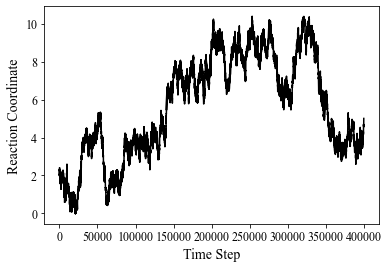

In [20]:
# remove equilibration phase

data_new = data[:,150:]

#MSM Parameters
#cluster data
numbins_q = 250  
v_min = 0.5
v_max = 10
qspace = np.linspace(v_min,v_max,numbins_q)

#discretize data
dtrajs = [np.digitize(data_new[k,:],qspace[1:]) for k in range(data.shape[0])] 

# plot example coordinates
plt.plot(data_new[5],c='black')
plt.xlabel('Time Step')
plt.ylabel('Reaction Coordinate')

# Compute reference - This takes quite some time, can also be skipped

In [59]:
# Parameters for simulation

#Simulation Paramters
n_steps_ref = 4000000
numsims_ref = 200
T = 1.5  
gamma = 50
m = 1
dt = 0.005
k_B = 1 # everything in units of k_B
sigma_square = 2 * k_B * T * gamma * m *(1./dt) 

#MSM Parameters
#bin simulations 
numbins_q = 250 
v_min = 0.5
v_max = 10
qspace = np.linspace(v_min,v_max,numbins_q)
#find center of bin


# Start position 
Xstart = np.linspace(1,10,numsims_ref) 
# Maxwell-Bolzmann most probable velocity 
v_prob = np.sqrt(2*k_B*T/m)
delta_start = v_prob*dt
# corresponding last steps
#randomly assign sign
np.random.seed(0)
Xstart_0 = Xstart + delta_start * np.random.choice([1,-1], numsims_ref)
Xlast=Xstart


In [ ]:
#initilize data
data_ref = np.zeros((numsims_ref,n_steps_ref))

#generate random numbers for simulation using seed to make it reproducible
np.random.seed(1)
all_random_ref = np.random.normal(loc=0.0, scale=1.0, size=(numsims_ref,n_steps_ref))

# Start MD Loop
for step in range(n_steps_ref):
    if step % 100000 == 0:
        print(step)
    for i in range(numsims_ref):


        # Get random force, normally distributed and multiply with sigma to get 
        # currect distribution
        curr_random = all_random_ref[i,step]
        R_x = np.sqrt(sigma_square) * curr_random 
        

        #unbiased force
        F_unbias = Evaluate_force(Xlast[i],weight_factor=1,dx=0.005)
        
        
        #Evolve position according to BKK algorithm
        r_2 = (1/(1 + gamma * dt/2)) * (2 * Xlast[i] - Xstart_0[i] + gamma * (dt/2) * (Xstart_0[i]) + (dt**2/m) * (R_x + F_unbias))
        
        #write new position to data
        data_ref[i,step] = r_2
        
        #Reset initial positions
        Xstart_0[i] = Xlast[i]
        Xlast[i] = r_2

# save data 
np.save('data_1_D_shallow_Gromos_4_wells_reference.npy', data_ref)
  

In [61]:
# load data
data_ref=np.load('data_1_D_shallow_Gromos_4_wells_reference.npy')

In [62]:
# remove equilibration phase
skipstep = 100 # only take every 100th step
numbins_q = 250 
v_min = 0.5
v_max = 10
qspace = np.linspace(v_min,v_max,numbins_q)
data_ref_new = data_ref[:,150::skipstep]
#discretize data
dtrajs_ref = [np.digitize(data_ref_new[k,:],qspace[1:]) for k in range(data_ref_new.shape[0])] 

# make MSM 
# get corresponding distribution

# plot energy from stationary distribution
lag_ref = 4000
orig_msm_ref  = msm.estimate_markov_model(dtrajs_ref, lag=lag_ref)
orig_distr_ref = orig_msm_ref.stationary_distribution

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  app.launch_new_instance()


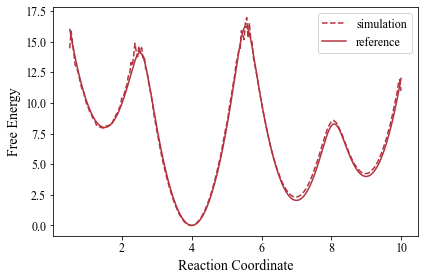

In [63]:
x = qspace
g = get_potential(x)
plt.plot(x, k_B*T*(-np.log(orig_distr_ref) - np.min(-np.log(orig_distr_ref)[5:-5])), '--', c=color_ref )

plt.ylabel('Free Energy')
plt.xlabel('Reaction Coordinate')
plt.plot(x,g, c=color_ref)

plt.legend(( 'simulation', 'reference'),loc='upper right')
plt.tight_layout()


plt.savefig('reference_eq_4000_lag.pdf', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None, format='pdf')

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


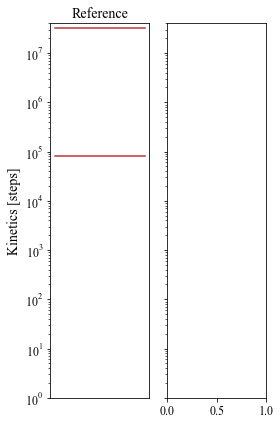

In [65]:
eigenvalues_ref = orig_msm_ref.eigenvalues()

# plot kinetic spectrum 
fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(4, 6))
for curr_d in range(6):
    ts_ref = -lag_ref*skipstep/np.log(eigenvalues_ref[curr_d+1])
    ax1.set_title('Reference')
    ax1.plot([0,1], [ts_ref, ts_ref], c=color_ref)
    ax1.set_ylabel('Kinetics [steps]')
    plt.yscale("log")
plt.ylim(1,40000000)

ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

fig.tight_layout()
plt. savefig('reference_kin_40_lag.pdf', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None, format='pdf')      

# Figure 1

## 1B Theory Figure with energy surface

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


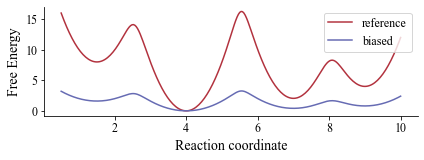

In [21]:
# Figure for Theory part

# plot data distribution
ax = plt.subplot(211)

x = qspace
g = get_potential(x)


ax.plot(x,g, c=color_ref)
ax.plot(x,g*weight_factor, c=color_sim)
ax.legend(('reference', 'biased'),loc='upper right')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Reaction coordinate')
ax.set_ylabel('Free Energy')
plt.tight_layout()
plt.savefig('Theory_fig.pdf', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None, format='pdf')

Figure A.2 and B.2. will be treated after the heatmaps in the chapter g-factor analysis

# Figure 2

## 2A.1 Theory figure to show the impact of coarse clustering

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


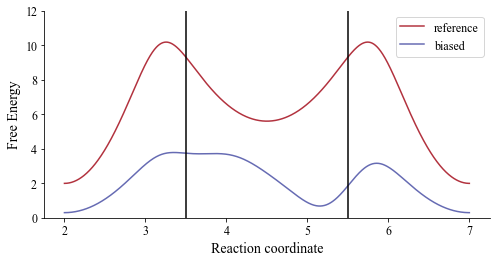

In [23]:
x = np.linspace(2,7,1001)
y_system = get_potential_theory(x)
y_system_bias = 0.4*get_potential_theory(x) + 1.6*gauss(x,4.1,0.4) - 1.5*gauss(x,5.25,0.32) -.5#1.9*gauss(x,4.1,0.5)

fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(7, 2.5*1.5))
ax1.plot(x,y_system,c=color_ref)
ax1.plot(x,y_system_bias,c=color_sim)

# plot cluster member line
ax1.plot([3.5,3.5],[0,12], c='black')
ax1.plot([5.5,5.5],[0,12], c='black')
ax1.set_ylim(0,12)
ax1.set_ylabel('Free Energy')
ax1.set_xlabel('Reaction coordinate')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend(('reference', 'biased'),loc='upper right')

fig.tight_layout()
plt.savefig('explain_g_factor.pdf', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None, format='pdf')

## 2B.1 Theory figure to show the impact of time-dependent bias

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


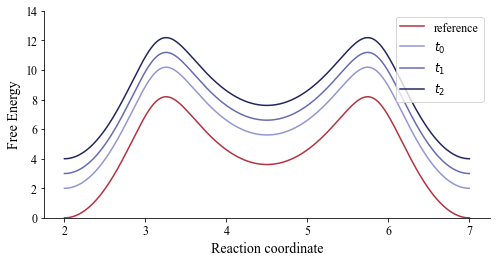

In [24]:
color_sim_1 = '#9297d4' 
color_sim_2 = '#22265c' 

x = np.linspace(2,7,1001)
y_system = get_potential_theory(x) -2
y_system_bias_t0 = get_potential_theory(x)  
y_system_bias_t1 = get_potential_theory(x)   +1
y_system_bias_t2 = get_potential_theory(x)  +2


fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(7, 2.5*1.5))
ax1.plot(x,y_system,c=color_ref)
ax1.plot(x,y_system_bias_t0,c=color_sim_1)
ax1.plot(x,y_system_bias_t1,c=color_sim)
ax1.plot(x,y_system_bias_t2,c=color_sim_2)


ax1.set_ylim(0,14)
ax1.set_ylabel('Free Energy')
ax1.set_xlabel('Reaction coordinate')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend(('reference',r'$t_0$', r'$t_1$', r'$t_2$'),loc='upper right')

fig.tight_layout()
plt.savefig('explain_time_factor.pdf', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None, format='pdf')

# To avoid double computations Figure 3 will be treated after Figure 4

# Figure 4

## 4 A + B Distribution of the simulations

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


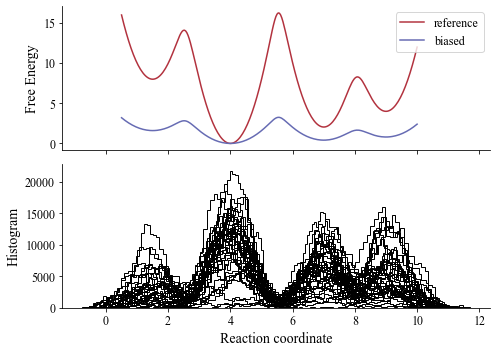

In [25]:
# plot data distribution
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(7, 5))

x = qspace
g = get_potential(x)

# make MSM 
# get corresponding distribution
# plot energy from stationary distribution
orig_msm  = msm.estimate_markov_model(dtrajs, lag=500)
orig_distr = orig_msm.stationary_distribution


# matplotlib histogram
for n in range(numsims):
    ax2.hist(data_new[n],  color='white',edgecolor = 'black',bins = 100, histtype='step')
ax1.plot(x,g, c=color_ref)
ax1.plot(x,g*weight_factor, c=color_sim)
ax1.legend(('reference', 'biased'),loc='upper right')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xlabel('Reaction coordinate')
ax2.set_ylabel('Histogram')
ax1.set_ylabel('Free Energy')
fig.tight_layout()
plt.savefig('histogram.pdf', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None, format='pdf')

## Weber-Pande Reweighting

In [26]:
count_traj = 0
tlag = 4000 # lagtime 
C = np.zeros((len(qspace),len(qspace)))
Rws = np.zeros((len(qspace),len(qspace)))

while count_traj < numsims:
    
    curr_sim = dtrajs[count_traj]
    
    #build count matrix without reweighting
    l = len(curr_sim)
    #start in state i go to state j
    for i in range(l- tlag):
        j = i + tlag
        C[int(curr_sim[i]),int(curr_sim[j])] = C[int(curr_sim[i]),int(curr_sim[j])] + 1 
    
    #build count matrix with reweighting
    for i in range(l- tlag):
        j = i + tlag
        Rws[int(curr_sim[i]),int(curr_sim[j])] = Rws[int(curr_sim[i]),int(curr_sim[j])] + np.exp(np.sum(A_diff[count_traj , i:j]))
    count_traj += 1

# get transition matrix from count matrix
P_rw, P_norm = get_transition_matrix(Rws, C)

## Girsanov Reweighting

In [27]:
count_traj = 0
tlag = 4000 # lagtime 
C_gir = np.zeros((len(qspace),len(qspace)))
Rws_gir = np.zeros((len(qspace),len(qspace)))
Rws_gir_no_energyterm = np.zeros((len(qspace),len(qspace)))

while count_traj < numsims:
    
    #build count matrix 
    curr_sim = dtrajs[count_traj]
    l = len(curr_sim)
    for i in range(l- tlag):
        j = i + tlag
        C_gir[int(curr_sim[i]),int(curr_sim[j])] = C_gir[int(curr_sim[i]),int(curr_sim[j])] + 1 
    
    #Reweight transition matrix based on actions at Markov time
    for i in range(l- tlag):
        j = i + tlag
        
        g_gir = np.exp((-1./(T*k_B)*energy[count_traj,i]))     #bias energy 
        w_gir = np.exp(np.sum(M_gir_I1[count_traj, i:j]- 0.5* M_gir_I2[count_traj, i:j]))
        
        Rws_gir[int(curr_sim[i]),int(curr_sim[j])] = Rws_gir[int(curr_sim[i]),int(curr_sim[j])] +  w_gir *g_gir
        Rws_gir_no_energyterm[int(curr_sim[i]),int(curr_sim[j])] = Rws_gir_no_energyterm[int(curr_sim[i]),int(curr_sim[j])] +  w_gir
    count_traj += 1
    

# get transition matrix from count matrix
P_rw_gir, P_norm_gir = get_transition_matrix(Rws_gir, C_gir)

## DHAM Reweighting

In [28]:
count_traj = 0
tlag = 40 # lagtime 
C = np.zeros((numbins_q,numbins_q))
Rws_DHAM = np.zeros((numbins_q,numbins_q))

# bias energy per state
u = (1-weight_factor)*get_potential(qspace)

while count_traj < numsims:
    #build count matrix 
    curr_sim = dtrajs[count_traj]
    l = len(curr_sim)
    for i in range(l- tlag):
        j = i + tlag
        # not reweighted
        C[int(curr_sim[i]),int(curr_sim[j])] = C[int(curr_sim[i]),int(curr_sim[j])] + 1 
        #reweighted DHAM
        DHAM_factor = np.exp(-((u[int(curr_sim[j])-1]-u[int(curr_sim[i])-1])/(2*k_B*T)))
        
        Rws_DHAM[int(curr_sim[i]),int(curr_sim[j])] = Rws_DHAM[int(curr_sim[i]),int(curr_sim[j])] + DHAM_factor
        
    count_traj += 1

# get transition matrix from count matrix
P_rw_DHAM, P_norm_DHAM = get_transition_matrix(Rws_DHAM, C)

## Figure 4C Weber-Pande 

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


slowest kinetics 1 has value (77801.33010628894-0j) for the biased simulation and (20307841.92672907-0j) after reweighting 
slowest kinetics 2 has value (17540.310588999848-0j) for the biased simulation and (111946.55902568299-0j) after reweighting 
slowest kinetics 3 has value (10727.101125060959-0j) for the biased simulation and (42151.437832305826-0j) after reweighting 
slowest kinetics 4 has value (2471.0520898459645-0j) for the biased simulation and (1497.3804985717472-0j) after reweighting 
slowest kinetics 5 has value (2220.358466204839-0j) for the biased simulation and (670.9951189933398+644.8392575368756j) after reweighting 
slowest kinetics 6 has value (1693.1640372440154-0j) for the biased simulation and (670.9951189933398-644.8392575368756j) after reweighting 


/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


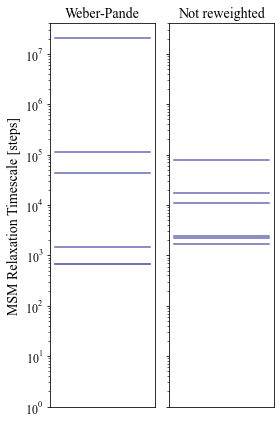

In [39]:
# get the kinetic comparison
tlag = 4000 # lagtime 
plot_kinetic_spectrum(P_rw, P_norm, name='Weber-Pande') 

## Figure 4C Girsanov

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


slowest kinetics 1 has value (77801.33010628894-0j) for the biased simulation and (20113555.710518938-0j) after reweighting 
slowest kinetics 2 has value (17540.310588999848-0j) for the biased simulation and (115476.69215881053-0j) after reweighting 
slowest kinetics 3 has value (10727.101125060959-0j) for the biased simulation and (42939.3348889939-0j) after reweighting 
slowest kinetics 4 has value (2471.0520898459645-0j) for the biased simulation and (1397.902170773736-0j) after reweighting 
slowest kinetics 5 has value (2220.358466204839-0j) for the biased simulation and (1270.6289041129096-0j) after reweighting 
slowest kinetics 6 has value (1693.1640372440154-0j) for the biased simulation and (636.5893921653534+630.4004193548438j) after reweighting 


/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


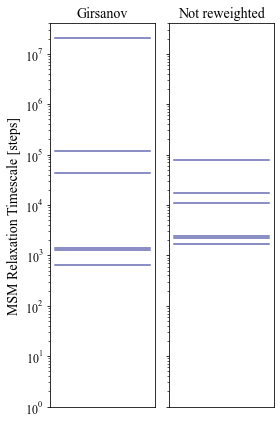

In [40]:
# get the kinetic comparison
tlag = 4000 # lagtime 
plot_kinetic_spectrum(P_rw_gir, P_norm_gir, name='Girsanov')

## Figure 4C DHAM

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


slowest kinetics 1 has value (86689.17765775173-0j) for the biased simulation and (19790766.38001246-0j) after reweighting 
slowest kinetics 2 has value (19636.654243071287-0j) for the biased simulation and (112928.91063181726-0j) after reweighting 
slowest kinetics 3 has value (11576.719130172827-0j) for the biased simulation and (39606.9660154121-0j) after reweighting 
slowest kinetics 4 has value (2704.9027630737855-0j) for the biased simulation and (1866.3079422530832-0j) after reweighting 
slowest kinetics 5 has value (2329.1410013290374-0j) for the biased simulation and (753.9482339016432-0j) after reweighting 
slowest kinetics 6 has value (1846.4239423558156-0j) for the biased simulation and (704.1545533333162-0j) after reweighting 


/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


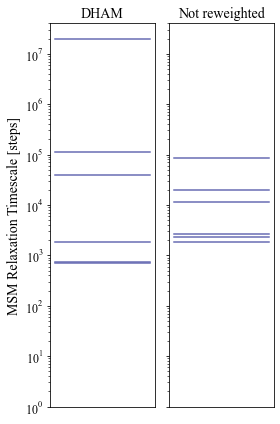

In [41]:
# get the kinetic comparison
tlag = 40 # lagtime 
plot_kinetic_spectrum(P_rw_DHAM, P_norm_DHAM, name='DHAM')

## Figure 4E Weber-Pande 

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


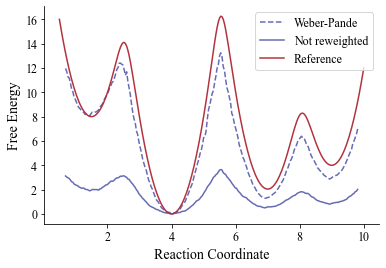

In [42]:
# plot the equilibrium distributions
x = qspace
plot_equilibrium(P_rw, P_norm, name='Weber-Pande')

## Figure 4E Girsanov

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


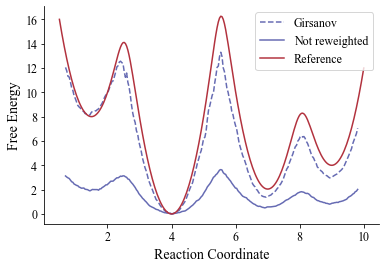

In [43]:
# plot the equilibrium distributions
plot_equilibrium(P_rw_gir, P_norm_gir, name='Girsanov')

## Figure 4E DHAM

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


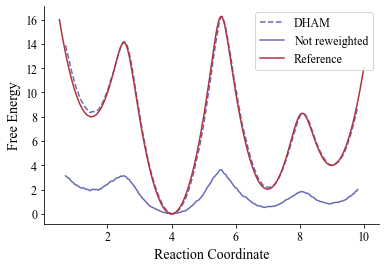

In [44]:
# plot the equilibrium distributions
plot_equilibrium(P_rw_DHAM, P_norm_DHAM, name='DHAM')

## Figure 4D Heatmaps

Heatmaps will be treated in a seperate section after Figure 6

# Figure 3

## 3B Difference between Weber-Pande and Girsanov reweighting path reweighting only

In [45]:
# get transition matrix from count matrix without energy reweighting
P_rw_gir_no_energyterm, P_norm_gir = get_transition_matrix(Rws_gir_no_energyterm, C_gir)

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


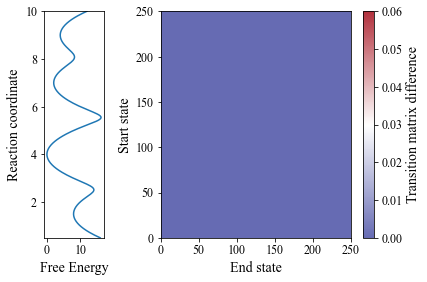

In [46]:
# Heatmap for differences without energy term

# probability difference matrix visual
fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 4]})

c = ax1.pcolor(np.abs(P_rw_gir_no_energyterm- P_rw), cmap=newcmp,vmax=0.06, vmin=0)
fig.colorbar(c, ax=ax1, label='Transition matrix difference')

ax1.set_xlabel('End state')
ax1.set_ylabel('Start state')
#plot energy at the side
x = qspace
g = get_potential(x)
ax0.plot(g,x)
ax0.set_ylim(0.5,10)
ax0.set_xlabel('Free Energy')
ax0.set_ylabel('Reaction coordinate')
fig.tight_layout(pad=1.0)

plt.savefig('Transition_matrix_difference_no_energy.pdf', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None, format='pdf')

## 3C Difference between Weber-Pande and Girsanov reweighting full method

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


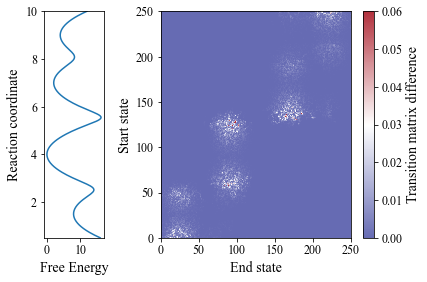

In [47]:
# Heatmap for differences with energy term

# probability difference matrix visual
fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 4]})

c = ax1.pcolor(np.abs(P_rw_gir- P_rw), cmap=newcmp,vmax=0.06, vmin=0)
fig.colorbar(c, ax=ax1, label='Transition matrix difference')

ax1.set_xlabel('End state')
ax1.set_ylabel('Start state')
#plot energy at the side
x = qspace
g = get_potential(x)
ax0.plot(g,x)
ax0.set_ylim(0.5,10)
ax0.set_xlabel('Free Energy')
ax0.set_ylabel('Reaction coordinate')
fig.tight_layout(pad=1.0)

plt.savefig('Transition_matrix_difference_energy.pdf', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None, format='pdf')

# Figure 5 

## Figure 5 A Short lagtime DHAM reweighting with and without correction factor

In [48]:
count_traj = 0
tlag = 40 # lagtime 
C = np.zeros((numbins_q,numbins_q))
Rws_DHAM = np.zeros((numbins_q,numbins_q))
Rws_DHAM_corr = np.zeros((numbins_q,numbins_q))

# bias energy per state
u = (1-weight_factor)*get_potential(qspace)

while count_traj < numsims:
    #build count matrix 
    curr_sim = dtrajs[count_traj]
    l = len(curr_sim)
    for i in range(l- tlag):
        j = i + tlag
        # not reweighted
        C[int(curr_sim[i]),int(curr_sim[j])] = C[int(curr_sim[i]),int(curr_sim[j])] + 1 
        #reweighted DHAM
        DHAM_factor = np.exp(-((u[int(curr_sim[j])-1]-u[int(curr_sim[i])-1])/(2*k_B*T)))
        
        Rws_DHAM[int(curr_sim[i]),int(curr_sim[j])] = Rws_DHAM[int(curr_sim[i]),int(curr_sim[j])] + DHAM_factor
        
        #reweighted DHAM+correction factor
        corr_factor = np.exp(-np.sum(A_corr[count_traj,i:j]))
        
        Rws_DHAM_corr[int(curr_sim[i]),int(curr_sim[j])] = Rws_DHAM_corr[int(curr_sim[i]),int(curr_sim[j])] + DHAM_factor*corr_factor
        
    count_traj += 1
    

# get transition matrix from count matrix
P_rw_DHAM, P_norm_DHAM = get_transition_matrix(Rws_DHAM, C)
P_rw_DHAM_corr, P_norm_DHAM_corr = get_transition_matrix(Rws_DHAM_corr, C)


/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


slowest kinetics 1 has value (86689.17765775173-0j) for the biased simulation and (19790766.38001246-0j) after reweighting 
slowest kinetics 2 has value (19636.654243071287-0j) for the biased simulation and (112928.91063181726-0j) after reweighting 
slowest kinetics 3 has value (11576.719130172827-0j) for the biased simulation and (39606.9660154121-0j) after reweighting 
slowest kinetics 4 has value (2704.9027630737855-0j) for the biased simulation and (1866.3079422530832-0j) after reweighting 
slowest kinetics 5 has value (2329.1410013290374-0j) for the biased simulation and (753.9482339016432-0j) after reweighting 
slowest kinetics 6 has value (1846.4239423558156-0j) for the biased simulation and (704.1545533333162-0j) after reweighting 


/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


slowest kinetics 1 has value (86689.17765775173-0j) for the biased simulation and (19680162.500430934-0j) after reweighting 
slowest kinetics 2 has value (19636.654243071287-0j) for the biased simulation and (112429.78838754416-0j) after reweighting 
slowest kinetics 3 has value (11576.719130172827-0j) for the biased simulation and (39532.29771299925-0j) after reweighting 
slowest kinetics 4 has value (2704.9027630737855-0j) for the biased simulation and (1729.1107429109184-0j) after reweighting 
slowest kinetics 5 has value (2329.1410013290374-0j) for the biased simulation and (752.4225787343692-0j) after reweighting 
slowest kinetics 6 has value (1846.4239423558156-0j) for the biased simulation and (705.7913208214626-0j) after reweighting 


/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


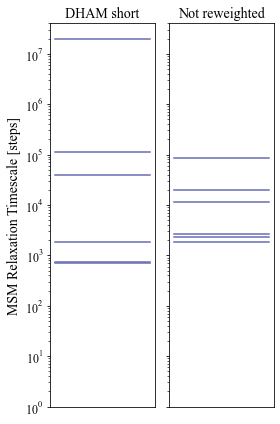

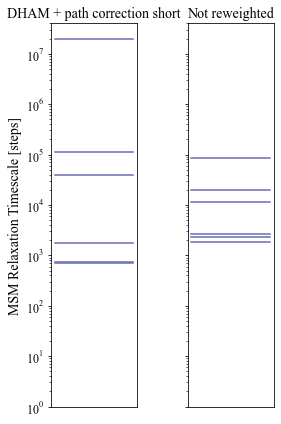

In [49]:
# get the kinetic comparison

plot_kinetic_spectrum(P_rw_DHAM, P_norm_DHAM, name='DHAM short')
plot_kinetic_spectrum(P_rw_DHAM_corr, P_norm_DHAM_corr, name='DHAM + path correction short')

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


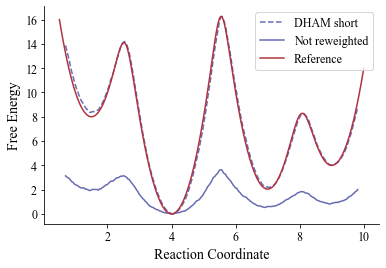

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


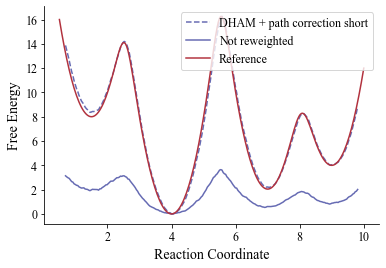

In [50]:
# plot the equilibrium distributions
plot_equilibrium(P_rw_DHAM, P_norm_DHAM, name='DHAM short')
plot_equilibrium(P_rw_DHAM_corr, P_norm_DHAM_corr, name='DHAM + path correction short')

## Figure 5 B Long lagtime DHAM reweighting with and without correction factor

In [51]:
count_traj = 0
tlag = 4000 # lagtime 
C = np.zeros((numbins_q,numbins_q))
Rws_DHAM = np.zeros((numbins_q,numbins_q))
Rws_DHAM_corr = np.zeros((numbins_q,numbins_q))

# bias energy per state
u = (1-weight_factor)*get_potential(qspace)

while count_traj < numsims:
    #build count matrix 
    curr_sim = dtrajs[count_traj]
    l = len(curr_sim)
    for i in range(l- tlag):
        j = i + tlag
        # not reweighted
        C[int(curr_sim[i]),int(curr_sim[j])] = C[int(curr_sim[i]),int(curr_sim[j])] + 1 
        #reweighted DHAM
        DHAM_factor = np.exp(-((u[int(curr_sim[j])-1]-u[int(curr_sim[i])-1])/(2*k_B*T)))
        
        Rws_DHAM[int(curr_sim[i]),int(curr_sim[j])] = Rws_DHAM[int(curr_sim[i]),int(curr_sim[j])] + DHAM_factor
        
        #reweighted DHAM+correction factor
        corr_factor = np.exp(-np.sum(A_corr[count_traj,i:j]))
        
        Rws_DHAM_corr[int(curr_sim[i]),int(curr_sim[j])] = Rws_DHAM_corr[int(curr_sim[i]),int(curr_sim[j])] + DHAM_factor*corr_factor 
        
    count_traj += 1
    

# get transition matrix from count matrix
P_rw_DHAM, P_norm_DHAM = get_transition_matrix(Rws_DHAM, C)
P_rw_DHAM_corr, P_norm_DHAM_corr = get_transition_matrix(Rws_DHAM_corr, C)

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


slowest kinetics 1 has value (77801.33010628894-0j) for the biased simulation and (96398.0036851843-0j) after reweighting 
slowest kinetics 2 has value (17540.310588999848-0j) for the biased simulation and (10445.075530266202-0j) after reweighting 
slowest kinetics 3 has value (10727.101125060959-0j) for the biased simulation and (6410.896366408388-0j) after reweighting 
slowest kinetics 4 has value (2471.0520898459645-0j) for the biased simulation and (1652.9405807707828-0j) after reweighting 
slowest kinetics 5 has value (2220.358466204839-0j) for the biased simulation and (1511.623868912044-0j) after reweighting 
slowest kinetics 6 has value (1693.1640372440154-0j) for the biased simulation and (1311.3862186758906-0j) after reweighting 


/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


slowest kinetics 1 has value (77801.33010628894-0j) for the biased simulation and (10789420.482530737-0j) after reweighting 
slowest kinetics 2 has value (17540.310588999848-0j) for the biased simulation and (35446.6475665586-0j) after reweighting 
slowest kinetics 3 has value (10727.101125060959-0j) for the biased simulation and (13458.712809626502-0j) after reweighting 
slowest kinetics 4 has value (2471.0520898459645-0j) for the biased simulation and (1420.492545532207-0j) after reweighting 
slowest kinetics 5 has value (2220.358466204839-0j) for the biased simulation and (690.7953508747934+618.5205369243434j) after reweighting 
slowest kinetics 6 has value (1693.1640372440154-0j) for the biased simulation and (690.7953508747934-618.5205369243434j) after reweighting 


/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


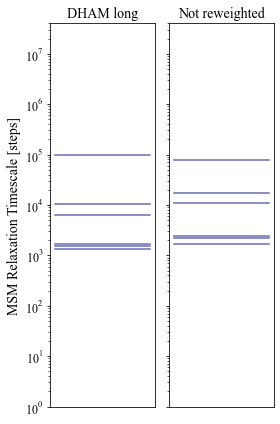

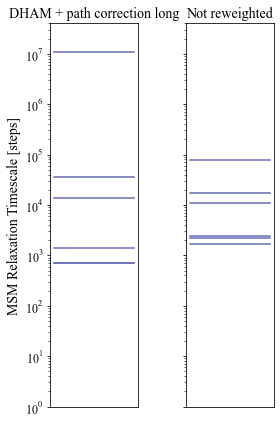

In [52]:
# get the kinetic comparison
# for text display: currently only works for python 2 --> return as pandas table instead? 

plot_kinetic_spectrum(P_rw_DHAM, P_norm_DHAM, name='DHAM long')
plot_kinetic_spectrum(P_rw_DHAM_corr, P_norm_DHAM_corr, name='DHAM + path correction long')

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


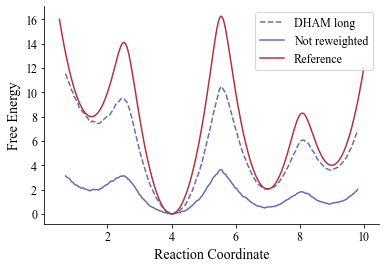

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


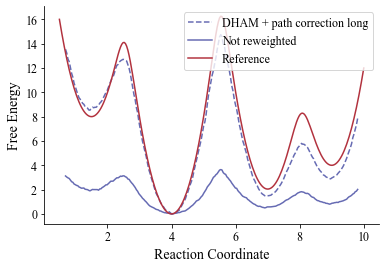

In [53]:
# plot the equilibrium distributions
plot_equilibrium(P_rw_DHAM, P_norm_DHAM, name='DHAM long')
plot_equilibrium(P_rw_DHAM_corr, P_norm_DHAM_corr, name='DHAM + path correction long')

## Figure 5C Heatmaps

Heatmaps will be treated in a seperate section after Figure 6

# Figure 6

## DHAM formula for long lagtimes, with lagtime = 400 steps

In [54]:
count_traj = 0
tlag = 400 # lagtime 
C = np.zeros((numbins_q,numbins_q))
Rws_DHAM_long = np.zeros((numbins_q,numbins_q))


# bias energy per state
u = (1-weight_factor)*get_potential(qspace)

while count_traj < numsims:
    #build count matrix 
    curr_sim = dtrajs[count_traj]
    l = len(curr_sim)
    for i in range(l- tlag-1):
        j = i + tlag
        # not reweighted
        C[int(curr_sim[i]),int(curr_sim[j])] = C[int(curr_sim[i]),int(curr_sim[j])] + 1 
        #reweighted DHAM
        DHAM_factor_long = np.exp(-((u[int(curr_sim[j])-1])/(k_B*T))) # DHAM long lagtime
        
        Rws_DHAM_long[int(curr_sim[i]),int(curr_sim[j])] = Rws_DHAM_long[int(curr_sim[i]),int(curr_sim[j])] + DHAM_factor_long
        
    count_traj += 1
    

# get transition matrix from count matrix
P_rw_DHAM_long, P_norm_DHAM = get_transition_matrix(Rws_DHAM_long, C)

## Figure 6A

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


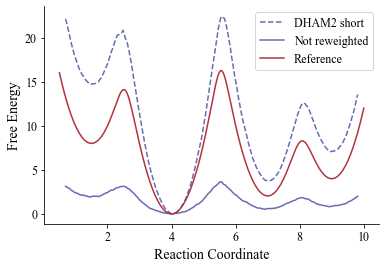

In [55]:
# equilibrium distribution
plot_equilibrium(P_rw_DHAM_long, P_norm_DHAM, name='DHAM2 short')

## Figure 6C 

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


slowest kinetics 1 has value (79371.32311209601-0j) for the biased simulation and (140226842.25130853-0j) after reweighting 
slowest kinetics 2 has value (17838.314272982832-0j) for the biased simulation and (90771.53538777775-0j) after reweighting 
slowest kinetics 3 has value (10730.435353907233-0j) for the biased simulation and (58709.07527852762-0j) after reweighting 
slowest kinetics 4 has value (2527.027499018742-0j) for the biased simulation and (794.347913618234-0j) after reweighting 
slowest kinetics 5 has value (2202.4917048461953-0j) for the biased simulation and (552.6450162651406-0j) after reweighting 
slowest kinetics 6 has value (1743.9384759163975-0j) for the biased simulation and (526.1784529533945-0j) after reweighting 


/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


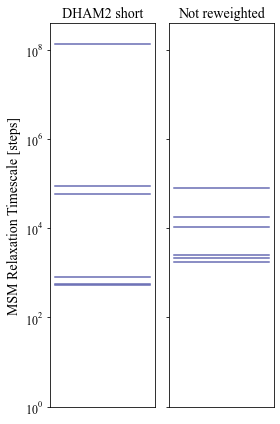

In [56]:
# get the kinetic comparison
plot_kinetic_spectrum(P_rw_DHAM_long, P_norm_DHAM, name='DHAM2 short', figure=True, ylim_set=400000000)

## DHAM formula for long lagtimes, with lagtime = 4000 steps

In [57]:
count_traj = 0
tlag = 4000 # lagtime 
C = np.zeros((numbins_q,numbins_q))
Rws_DHAM_long = np.zeros((numbins_q,numbins_q))


# bias energy per state
u = (1-weight_factor)*get_potential(qspace)

while count_traj < numsims:
    #build count matrix 
    curr_sim = dtrajs[count_traj]
    l = len(curr_sim)
    for i in range(l- tlag-1):
        j = i + tlag
        # not reweighted
        C[int(curr_sim[i]),int(curr_sim[j])] = C[int(curr_sim[i]),int(curr_sim[j])] + 1 
        #reweighted DHAM
        DHAM_factor_long = np.exp(-((u[int(curr_sim[j])-1])/(k_B*T))) # DHAM long lagtime
        
        Rws_DHAM_long[int(curr_sim[i]),int(curr_sim[j])] = Rws_DHAM_long[int(curr_sim[i]),int(curr_sim[j])] + DHAM_factor_long
        
    count_traj += 1
    

# get transition matrix from count matrix
P_rw_DHAM_long, P_norm_DHAM = get_transition_matrix(Rws_DHAM_long, C)

## Figure 6B

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


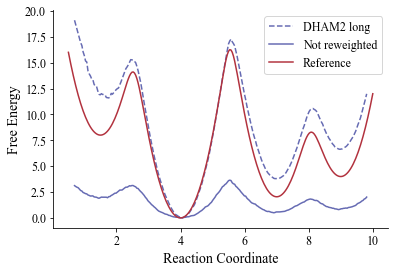

In [58]:
# equilibrium distribution
plot_equilibrium(P_rw_DHAM_long, P_norm_DHAM, name='DHAM2 long')

## Figure 6F

/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


slowest kinetics 1 has value (77801.36574669233-0j) for the biased simulation and (73232.44047511308-0j) after reweighting 
slowest kinetics 2 has value (17540.290936720972-0j) for the biased simulation and (8869.368406646166-0j) after reweighting 
slowest kinetics 3 has value (10727.120557236123-0j) for the biased simulation and (2204.180471649236-0j) after reweighting 
slowest kinetics 4 has value (2471.055591687477-0j) for the biased simulation and (1269.7994932324311-0j) after reweighting 
slowest kinetics 5 has value (2220.370894158299-0j) for the biased simulation and (1179.782858719615-0j) after reweighting 
slowest kinetics 6 has value (1693.171965191494-0j) for the biased simulation and (669.5164029542126+464.3603177607291j) after reweighting 


/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/Users/stlinker/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


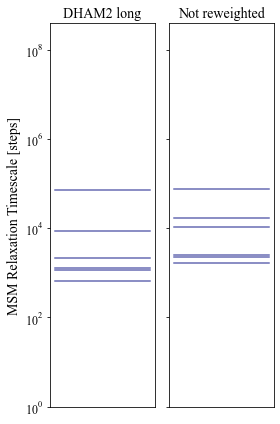

In [59]:
# get the kinetic comparison
plot_kinetic_spectrum(P_rw_DHAM_long, P_norm_DHAM, name='DHAM2 long', figure=True, ylim_set=400000000)

## Figure 6 D, E

In [85]:
# only biased 
# define inclusion level
current_bias = numsims # in # simulations 

lagtime_pos = [ 10, 40, 100, 400, 1000, 4000, 10000]
cluster_pos = [25, 50, 250, 500, 2500]

reference_kinetics = 29132157


performance_dict_DHAM_long_original = {}
performance_dict_DHAM_long_rw = {}

for cluster_n in cluster_pos:
    
    #discretize data
    qspace = np.linspace(v_min,v_max,cluster_n)
    u = (1-weight_factor)*get_potential(qspace)
    dtrajs_param = [np.digitize(data_new[k,:],qspace[1:]) for k in range(data.shape[0])]
    for lagtime in lagtime_pos:
    
        name = str(cluster_n)+'_'+str(lagtime)
        C = np.zeros((len(qspace),len(qspace)))
        Rws_DHAM_long = np.zeros((len(qspace),len(qspace)))
        
        print(name)
        count_traj = 0

        while count_traj < current_bias:

                
            #build count matrix 
            curr_sim = dtrajs_param[count_traj]
            l = len(curr_sim)

            # Make all transition Matrices
            for i in range(l- lagtime):
                j = i + lagtime
                    
                # Not reweighted transition matrix
                C[int(curr_sim[i]),int(curr_sim[j])] = C[int(curr_sim[i]),int(curr_sim[j])] + 1 
                    
                # DHAM reweighting
                DHAM_factor_long = np.exp(-((u[int(curr_sim[j])-1])/(k_B*T))) # DHAM long lagtime
                Rws_DHAM_long[int(curr_sim[i]),int(curr_sim[j])] = Rws_DHAM_long[int(curr_sim[i]),int(curr_sim[j])] + DHAM_factor_long
                
                
                      
            count_traj += 1

        ###
        # Write data into dictionary
        ###
        
        ### DHAM_long ###     
        try:

            #Normalize counts matrix
            P_rw_DHAM_long, P_norm_DHAM_long = get_transition_matrix(Rws_DHAM_long, C)
            # make markov model for kinetics 
            eigenvalues_rw_DHAM_long, eigenvalues_DHAM_long = plot_kinetic_spectrum(P_rw_DHAM_long, P_norm_DHAM_long, name='DHAM_long', figure=False)

            print('Kinetics DHAM_long [reweight, not reweight]')
            print(-lagtime/np.log(eigenvalues_rw_DHAM_long[1]), -lagtime/np.log(eigenvalues_DHAM_long[1]))
            
            # save in dictionary to later make heatmap plot
            performance_dict_DHAM_long_original[name] = -lagtime/np.log(eigenvalues_DHAM_long[:4])
            performance_dict_DHAM_long_rw[name] = -lagtime/np.log(eigenvalues_rw_DHAM_long[:4])
            
        except: 
            print(' DHAM_long disconnected', cluster_n, lagtime)
            # save in dictionary to later make heatmap plot
            performance_dict_DHAM_long_original[name] = 0
            performance_dict_DHAM_long_rw[name] = 0
            
            
    

25_10
Kinetics DHAM_long [reweight, not reweight]
(269631522.3095803, 17223.033417349507)
25_40
Kinetics DHAM_long [reweight, not reweight]
(437102055.44309974, 29083.090287720916)
25_100
Kinetics DHAM_long [reweight, not reweight]
(456522911.77519757, 43846.79928724668)
25_400
Kinetics DHAM_long [reweight, not reweight]
(39992372.38414482, 65627.73119137733)
25_1000
Kinetics DHAM_long [reweight, not reweight]
((2680616.8783554723-0j), (73196.07513040364-0j))
25_4000
Kinetics DHAM_long [reweight, not reweight]
((61865.87176487831-0j), (76246.26457373232-0j))
25_10000
Kinetics DHAM_long [reweight, not reweight]
((36980.069826019884-0j), (79550.29782330668-0j))


/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in divide
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in divide


50_10
Kinetics DHAM_long [reweight, not reweight]
(3869713966.32651, 35694.35716098295)
50_40
Kinetics DHAM_long [reweight, not reweight]
(4990268357.361926, 56538.40841230783)
50_100
Kinetics DHAM_long [reweight, not reweight]
(2908650425.757111, 68688.01470587734)
50_400
Kinetics DHAM_long [reweight, not reweight]
((123206794.24564242-0j), (75602.91826688245-0j))
50_1000
Kinetics DHAM_long [reweight, not reweight]
((4106325.883305507-0j), (77553.34174510188-0j))
50_4000
Kinetics DHAM_long [reweight, not reweight]
((73781.06703761802-0j), (77452.71693224213-0j))
50_10000
Kinetics DHAM_long [reweight, not reweight]
((37106.37796370344-0j), (80076.6769274572-0j))
250_10
Kinetics DHAM_long [reweight, not reweight]
((29452732314.729824-0j), (110669.75327086875-0j))
250_40
Kinetics DHAM_long [reweight, not reweight]
((16075862477.46571-0j), (86689.17765779348-0j))
250_100
Kinetics DHAM_long [reweight, not reweight]
((6606120666.525494-0j), (82604.68948938716-0j))
250_400
Kinetics DHAM_long

('current eigenvalue is:', 1)


/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


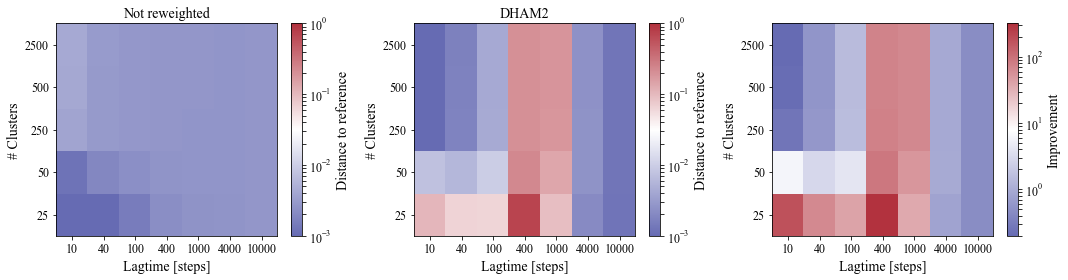

In [91]:
#save the dictionaries 

np.save('performance_dict_DHAM_long_original.npy', performance_dict_DHAM_long_original)
np.save('performance_dict_DHAM_long_rw.npy', performance_dict_DHAM_long_rw)

reference_kin = [29049528, 117247, 38157] 
lagtime_pos = [ 10, 40, 100, 400, 1000, 4000, 10000]
cluster_pos = [25, 50, 250, 500, 2500]

make_heatmap(performance_dict_DHAM_long_rw, performance_dict_DHAM_long_original, reference_kin, eigenvalue_number=1, name_plot='DHAM2')

# Heatmaps for Figure 4 + 5

In [74]:
# only biased 
# define inclusion level
current_bias = numsims # in # simulations 

lagtime_pos = [ 10, 40, 100, 400, 1000, 4000, 10000]
cluster_pos = [25, 50, 250, 500, 2500]

reference_kinetics = 29132157  

performance_dict_weber_original = {}
performance_dict_weber_rw = {}
performance_dict_girsanov_original = {}
performance_dict_girsanov_rw = {}
performance_dict_DHAM_original = {}
performance_dict_DHAM_rw = {}
performance_dict_corr_original = {}
performance_dict_corr_rw = {}

for cluster_n in cluster_pos:
    
    #discretize data
    qspace = np.linspace(v_min,v_max,cluster_n)
    u = (1-weight_factor)*get_potential(qspace)
    dtrajs_param = [np.digitize(data_new[k,:],qspace[1:]) for k in range(data.shape[0])]
    for lagtime in lagtime_pos:
    
        name = str(cluster_n)+'_'+str(lagtime)
        C = np.zeros((len(qspace),len(qspace)))
        Rws_weber = np.zeros((len(qspace),len(qspace)))
        Rws_girsanov = np.zeros((len(qspace),len(qspace)))
        Rws_DHAM = np.zeros((len(qspace),len(qspace)))
        Rws_corr = np.zeros((len(qspace),len(qspace)))
        

        print(name)
        count_traj = 0

        while count_traj < current_bias:

                
            #build count matrix 
            curr_sim = dtrajs_param[count_traj]
            l = len(curr_sim)

            # Make all transition Matrices
            for i in range(l- lagtime):
                j = i + lagtime
                    
                # Not reweighted transition matrix
                C[int(curr_sim[i]),int(curr_sim[j])] = C[int(curr_sim[i]),int(curr_sim[j])] + 1 
                    
                #Reweight transition matrix Weber-Pande
                Rws_weber[int(curr_sim[i]),int(curr_sim[j])] = Rws_weber[int(curr_sim[i]),int(curr_sim[j])] + np.exp(np.sum(A_diff[count_traj , i:j]))
                    
                #Reweight transition matrix Girsanov
                g_gir = np.exp((-1./(T*k_B)*energy[count_traj,i]))     #bias energy 
                w_gir = np.exp(np.sum(M_gir_I1[count_traj, i:j]- 0.5* M_gir_I2[count_traj, i:j]))
                Rws_girsanov[int(curr_sim[i]),int(curr_sim[j])] = Rws_girsanov[int(curr_sim[i]),int(curr_sim[j])] +  w_gir*g_gir
                    
                # DHAM reweighting
                DHAM_factor = np.exp(-((u[int(curr_sim[j])-1]-u[int(curr_sim[i])-1])/(2*k_B*T)))
                Rws_DHAM[int(curr_sim[i]),int(curr_sim[j])] = Rws_DHAM[int(curr_sim[i]),int(curr_sim[j])] + DHAM_factor
                
                # DHAM reweighting with correction
                corr_factor = np.exp(-np.sum(A_corr[count_traj,i:j]))
                Rws_corr[int(curr_sim[i]),int(curr_sim[j])] = Rws_corr[int(curr_sim[i]),int(curr_sim[j])] + DHAM_factor*corr_factor
                      
            count_traj += 1

        ###
        # Write data into dictionary
        ###
        
        
        ### Weber-Pande ###     
        try:

            #Normalize counts matrix
            P_rw_weber, P_norm_weber = get_transition_matrix(Rws_weber, C)
            # make markov model for kinetics 
            eigenvalues_rw_weber, eigenvalues_weber = plot_kinetic_spectrum(P_rw_weber, P_norm_weber, name='Weber-Pande', figure=False)

            print('Kinetics Weber-Pande [reweight, not reweight]')
            print(-lagtime/np.log(eigenvalues_rw_weber[1]), -lagtime/np.log(eigenvalues_weber[1]))
            
            # save in dictionary to later make heatmap plot
            performance_dict_weber_original[name] = -lagtime/np.log(eigenvalues_weber[:4])
            performance_dict_weber_rw[name] = -lagtime/np.log(eigenvalues_rw_weber[:4])
            
        except: 
            print(' Weber-Pande disconnected', cluster_n, lagtime)
            # save in dictionary to later make heatmap plot
            performance_dict_weber_original[name] = 0
            performance_dict_weber_rw[name] = 0
            
        ### Girsanov ###     
        try:

            #Normalize counts matrix
            P_rw_girsanov, P_norm_girsanov = get_transition_matrix(Rws_girsanov, C)
            # make markov model for kinetics 
            eigenvalues_rw_girsanov, eigenvalues_girsanov = plot_kinetic_spectrum(P_rw_girsanov, P_norm_girsanov, name='Girsanov', figure=False)

            print('Kinetics Girsanov [reweight, not reweight]')
            print(-lagtime/np.log(eigenvalues_rw_girsanov[1]), -lagtime/np.log(eigenvalues_girsanov[1]))
            
            # save in dictionary to later make heatmap plot
            performance_dict_girsanov_original[name] = -lagtime/np.log(eigenvalues_girsanov[:4])
            performance_dict_girsanov_rw[name] = -lagtime/np.log(eigenvalues_rw_girsanov[:4])
            
        except: 
            print(' Girsanov disconnected', cluster_n, lagtime)
            # save in dictionary to later make heatmap plot
            performance_dict_girsanov_original[name] = 0
            performance_dict_girsanov_rw[name] = 0
            
        ### DHAM ###     
        try:

            #Normalize counts matrix
            P_rw_DHAM, P_norm_DHAM = get_transition_matrix(Rws_DHAM, C)
            # make markov model for kinetics 
            eigenvalues_rw_DHAM, eigenvalues_DHAM = plot_kinetic_spectrum(P_rw_DHAM, P_norm_DHAM, name='DHAM', figure=False)

            print('Kinetics DHAM [reweight, not reweight]')
            print(-lagtime/np.log(eigenvalues_rw_DHAM[1]), -lagtime/np.log(eigenvalues_DHAM[1]))
            
            # save in dictionary to later make heatmap plot
            performance_dict_DHAM_original[name] = -lagtime/np.log(eigenvalues_DHAM[:4])
            performance_dict_DHAM_rw[name] = -lagtime/np.log(eigenvalues_rw_DHAM[:4])
            
        except: 
            print(' DHAM disconnected', cluster_n, lagtime)
            # save in dictionary to later make heatmap plot
            performance_dict_DHAM_original[name] = 0
            performance_dict_DHAM_rw[name] = 0
            
            
        ### corr_factor ###     
        try:

            #Normalize counts matrix
            P_rw_corr, P_norm_corr = get_transition_matrix(Rws_corr, C)
            # make markov model for kinetics 
            eigenvalues_rw_corr, eigenvalues_corr = plot_kinetic_spectrum(P_rw_corr, P_norm_corr, name='DHAM_corr', figure=False)

            print('Kinetics DHAM_corr [reweight, not reweight]')
            print(-lagtime/np.log(eigenvalues_rw_corr[1]), -lagtime/np.log(eigenvalues_corr[1]))
            
            # save in dictionary to later make heatmap plot
            performance_dict_corr_original[name] = -lagtime/np.log(eigenvalues_corr[:4])
            performance_dict_corr_rw[name] = -lagtime/np.log(eigenvalues_rw_corr[:4])
            
        except: 
            print(' DHAM_corr disconnected', cluster_n, lagtime)
            # save in dictionary to later make heatmap plot
            performance_dict_corr_original[name] = 0
            performance_dict_corr_rw[name] = 0
            

25_10
Kinetics Weber-Pande [reweight, not reweight]
(17633.81627644882, 17223.033417349507)
Kinetics Girsanov [reweight, not reweight]
(284982.38552205154, 17223.033417349507)
Kinetics DHAM [reweight, not reweight]
(795163.0312056382, 17223.033417349507)
Kinetics DHAM_corr [reweight, not reweight]
(807611.7108608434, 17223.033417349507)
25_40
Kinetics Weber-Pande [reweight, not reweight]
(31279.945352304498, 29083.090287720916)
Kinetics Girsanov [reweight, not reweight]
(291854.8160377522, 29083.090287720916)
Kinetics DHAM [reweight, not reweight]
(1316022.474154039, 29083.090287720916)
Kinetics DHAM_corr [reweight, not reweight]
(1383873.8615056118, 29083.090287720916)
25_100
Kinetics Weber-Pande [reweight, not reweight]
(50465.616325832736, 43846.79928724668)
Kinetics Girsanov [reweight, not reweight]
(223682.19689585903, 43846.79928724668)
Kinetics DHAM [reweight, not reweight]
(1848217.4062016534, 43846.79928724668)
Kinetics DHAM_corr [reweight, not reweight]
(2013550.286812793, 43

/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: divide by zero encountered in divide



Kinetics Weber-Pande [reweight, not reweight]
(857422.6220813747, 65627.73119137733)
Kinetics Girsanov [reweight, not reweight]
(1914955.5053934867, 65627.73119137733)
Kinetics DHAM [reweight, not reweight]
(1208046.3742534644, 65627.73119137733)
Kinetics DHAM_corr [reweight, not reweight]
(1706999.9184619999, 65627.73119137733)
25_1000
Kinetics Weber-Pande [reweight, not reweight]
((4111342.1270951014-0j), (73196.07513040364-0j))
Kinetics Girsanov [reweight, not reweight]
((6517613.220078844-0j), (73196.07513040364-0j))
Kinetics DHAM [reweight, not reweight]
((480416.6825929166-0j), (73196.07513040364-0j))
Kinetics DHAM_corr [reweight, not reweight]
((1665319.2061354255-0j), (73196.07513040364-0j))
25_4000
Kinetics Weber-Pande [reweight, not reweight]
((14091762.72082537-0j), (76246.26457373232-0j))
Kinetics Girsanov [reweight, not reweight]
((19276985.25316325-0j), (76246.26457373232-0j))
Kinetics DHAM [reweight, not reweight]
((86029.762486055-0j), (76246.26457373232-0j))
Kinetics 

/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in divide
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in divide


Kinetics Weber-Pande [reweight, not reweight]
((18465459.65373729-0j), (79550.29782330668-0j))
Kinetics Girsanov [reweight, not reweight]
((21630813.65173369-0j), (79550.29782330668-0j))
Kinetics DHAM [reweight, not reweight]
((61213.054341465635-0j), (79550.29782330668-0j))
Kinetics DHAM_corr [reweight, not reweight]
((5000010.461918964-0j), (79550.29782330668-0j))


/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in divide
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in divide
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in divide
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in divide
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: divide by zero encountered in divide
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in divide
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:151: RuntimeWarning: divide by zero encountered in divide
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py

50_10
Kinetics Weber-Pande [reweight, not reweight]
(36645.61804335492, 35694.35716098295)
Kinetics Girsanov [reweight, not reweight]
(221184.07547385094, 35694.35716098295)
Kinetics DHAM [reweight, not reweight]
(5470171.525570809, 35694.35716098295)
Kinetics DHAM_corr [reweight, not reweight]
(5554644.060257136, 35694.35716098295)
50_40
Kinetics Weber-Pande [reweight, not reweight]
(58829.19199843796, 56538.40841230783)
Kinetics Girsanov [reweight, not reweight]
(134110.14350858898, 56538.40841230783)
Kinetics DHAM [reweight, not reweight]
(8101626.080423104, 56538.40841230783)
Kinetics DHAM_corr [reweight, not reweight]
(8388766.743636427, 56538.40841230783)
50_100
Kinetics Weber-Pande [reweight, not reweight]
(71424.62550378687, 68688.01470587734)
Kinetics Girsanov [reweight, not reweight]
(102786.64480822747, 68688.01470587734)
Kinetics DHAM [reweight, not reweight]
(7703599.922009646, 68688.01470587734)
Kinetics DHAM_corr [reweight, not reweight]
(8060707.344714559, 68688.0147058

/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in divide
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in divide


250_40
Kinetics Weber-Pande [reweight, not reweight]
((86424.63126400282-0j), (86689.17765771001-0j))
Kinetics Girsanov [reweight, not reweight]
((81184.58444962018-0j), (86689.17765771001-0j))
Kinetics DHAM [reweight, not reweight]
((19790766.363705702-0j), (86689.17765771001-0j))
Kinetics DHAM_corr [reweight, not reweight]
((19680162.48968093-0j), (86689.17765771001-0j))
250_100
Kinetics Weber-Pande [reweight, not reweight]
((80856.85511855515-0j), (82604.68948940992-0j))
Kinetics Girsanov [reweight, not reweight]
((77920.53474675427-0j), (82604.68948940992-0j))
Kinetics DHAM [reweight, not reweight]
((13809877.510262193-0j), (82604.68948940992-0j))
Kinetics DHAM_corr [reweight, not reweight]
((13732498.53534351-0j), (82604.68948940992-0j))
250_400
Kinetics Weber-Pande [reweight, not reweight]
((1716115.9351138112-0j), (79370.66545130605-0j))
Kinetics Girsanov [reweight, not reweight]
((1812894.4653961696-0j), (79370.66545130605-0j))
Kinetics DHAM [reweight, not reweight]
((3296405.9

/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in divide
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in divide


Kinetics Girsanov [reweight, not reweight]
((20028167.48015563-0j), (77816.19116300688-0j))
Kinetics DHAM [reweight, not reweight]
((95662.4645692022-0j), (77816.19116300688-0j))
Kinetics DHAM_corr [reweight, not reweight]
((10832965.081462465-0j), (77816.19116300688-0j))
2500_10000
Kinetics Weber-Pande [reweight, not reweight]
((20318146.21263719-0j), (80214.35584722887-0j))
Kinetics Girsanov [reweight, not reweight]
((19652045.63714643-0j), (80214.35584722887-0j))
Kinetics DHAM [reweight, not reweight]
((60598.95820035027-0j), (80214.35584722887-0j))
Kinetics DHAM_corr [reweight, not reweight]
((11640916.6428626-0j), (80214.35584722887-0j))


In [75]:
#save the dictionaries 

np.save('performance_dict_girsanov_original.npy', performance_dict_girsanov_original)
np.save('performance_dict_girsanov_rw.npy', performance_dict_girsanov_rw)
np.save('performance_dict_DHAM_original.npy',performance_dict_DHAM_original)
np.save('performance_dict_DHAM_rw.npy', performance_dict_DHAM_rw)
np.save('performance_dict_DHAM_corr_original.npy',performance_dict_corr_original)
np.save('performance_dict_DHAM_corr_rw.npy', performance_dict_corr_rw)
np.save('performance_dict_weber_original.npy',performance_dict_weber_original)
np.save('performance_dict_weber_rw.npy', performance_dict_weber_rw)

In [38]:
# load the dictionaries 

performance_dict_girsanov_original = np.load('performance_dict_girsanov_original.npy').item()
performance_dict_girsanov_rw = np.load('performance_dict_girsanov_rw.npy').item()
performance_dict_DHAM_original = np.load('performance_dict_DHAM_original.npy').item()
performance_dict_DHAM_rw = np.load('performance_dict_DHAM_rw.npy').item()
performance_dict_weber_original = np.load('performance_dict_weber_original.npy').item()
performance_dict_weber_rw = np.load('performance_dict_weber_rw.npy').item()
performance_dict_corr_original = np.load('performance_dict_DHAM_corr_original.npy').item()
performance_dict_corr_rw = np.load('performance_dict_DHAM_corr_rw.npy').item()

## Figure 4D

('current eigenvalue is:', 1)


/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


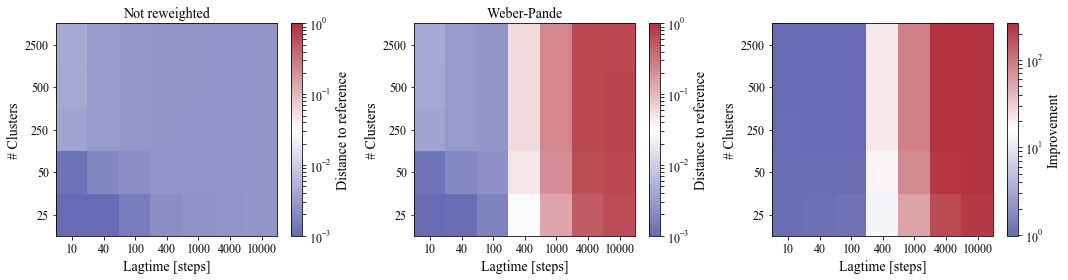

In [34]:
reference_kin = [29049528, 117247, 38157] 
lagtime_pos = [ 10, 40, 100, 400, 1000, 4000, 10000]
cluster_pos = [25, 50, 250, 500, 2500]

make_heatmap(performance_dict_weber_rw, performance_dict_weber_original, reference_kin, eigenvalue_number=1, name_plot='Weber-Pande')

('current eigenvalue is:', 1)


/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


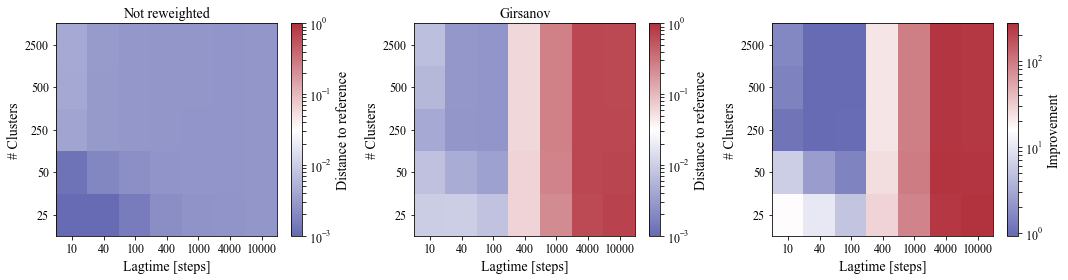

In [35]:
make_heatmap(performance_dict_girsanov_rw, performance_dict_girsanov_original, reference_kin, eigenvalue_number=1, name_plot='Girsanov')

## Figure 4D and 5 C

('current eigenvalue is:', 1)


/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


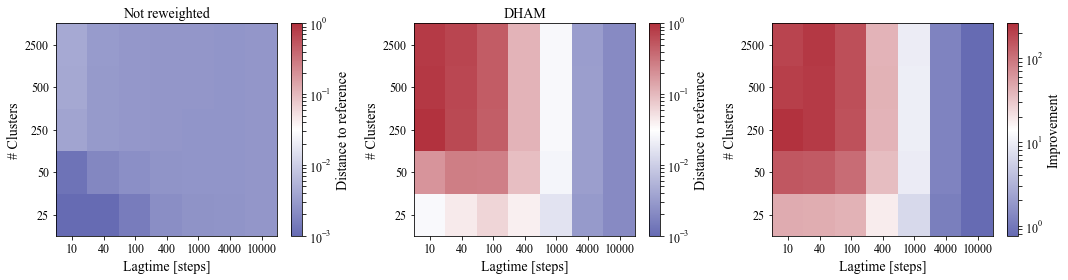

In [36]:
make_heatmap(performance_dict_DHAM_rw, performance_dict_DHAM_original, reference_kin, eigenvalue_number=1, name_plot='DHAM')

## Figure 5C

('current eigenvalue is:', 1)


/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


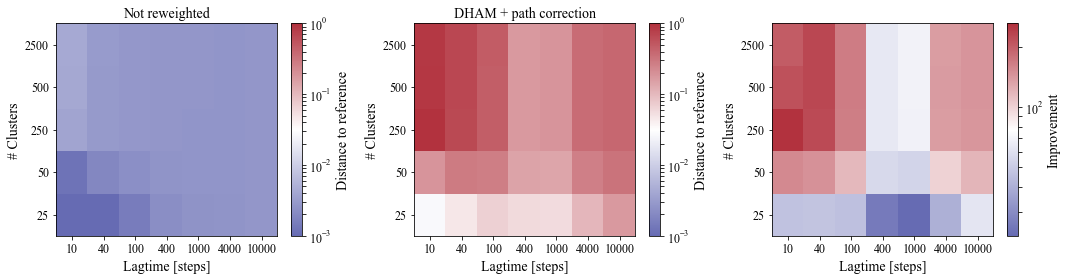

In [42]:
make_heatmap(performance_dict_corr_rw, performance_dict_corr_original, reference_kin, eigenvalue_number=1, name_plot='DHAM + path correction')

# Figure 1 g-factor

## Test different coarseness parameters

In [98]:
# only biased 
# define inclusion level
current_bias = numsims # in # simulations 

lagtime_pos = [4000]
cluster_pos = [5, 10, 25, 250]

reference_kin = [29049528, 117247, 38157] 
reference_kinetics = 29132157

performance_dict_weber_original_test_coarsness = {}
performance_dict_weber_rw_test_coarsness = {}
performance_dict_girsanov_original_test_coarsness = {}
performance_dict_girsanov_rw_test_coarsness = {}


for cluster_n in cluster_pos:
    
    #discretize data
    qspace = np.linspace(v_min,v_max,cluster_n)
    u = (1-weight_factor)*get_potential(qspace)
    dtrajs_param = [np.digitize(data_new[k,:],qspace[1:]) for k in range(data.shape[0])]
    for lagtime in lagtime_pos:
    
        name = str(cluster_n)+'_'+str(lagtime)
        C = np.zeros((len(qspace),len(qspace)))
        Rws_weber = np.zeros((len(qspace),len(qspace)))
        Rws_girsanov = np.zeros((len(qspace),len(qspace)))
        

        print(name)
        count_traj = 0

        while count_traj < current_bias:

                
            #build count matrix 
            curr_sim = dtrajs_param[count_traj]
            l = len(curr_sim)

            # Make all transition Matrices
            for i in range(l- lagtime):
                j = i + lagtime
                    
                # Not reweighted transition matrix
                C[int(curr_sim[i]),int(curr_sim[j])] = C[int(curr_sim[i]),int(curr_sim[j])] + 1 
                    
                #Reweight transition matrix Weber-Pande
                Rws_weber[int(curr_sim[i]),int(curr_sim[j])] = Rws_weber[int(curr_sim[i]),int(curr_sim[j])] + np.exp(np.sum(A_diff[count_traj , i:j]))
                    
                #Reweight transition matrix Girsanov
                g_gir = np.exp((-1./(T*k_B)*energy[count_traj,i]))     #bias energy 
                w_gir = np.exp(np.sum(M_gir_I1[count_traj, i:j]- 0.5* M_gir_I2[count_traj, i:j]))
                Rws_girsanov[int(curr_sim[i]),int(curr_sim[j])] = Rws_girsanov[int(curr_sim[i]),int(curr_sim[j])] +  w_gir*g_gir
                      
            count_traj += 1

        ###
        # Write data into dictionary
        ###
        
        
        ### Weber-Pande ###     
        try:

            #Normalize counts matrix
            P_rw_weber, P_norm_weber = get_transition_matrix(Rws_weber, C)
            # make markov model for kinetics 
            eigenvalues_rw_weber, eigenvalues_weber = plot_kinetic_spectrum(P_rw_weber, P_norm_weber, name='Weber-Pande', figure=False)

            print('Kinetics Weber-Pande [reweight, not reweight]')
            print(-lagtime/np.log(eigenvalues_rw_weber[1]), -lagtime/np.log(eigenvalues_weber[1]))
            
            # save in dictionary to later make heatmap plot
            performance_dict_weber_original_test_coarsness[name] = -lagtime/np.log(eigenvalues_weber[:4])
            performance_dict_weber_rw_test_coarsness[name] = -lagtime/np.log(eigenvalues_rw_weber[:4])
            
        except: 
            print(' Weber-Pande disconnected', cluster_n, lagtime)
            # save in dictionary to later make heatmap plot
            performance_dict_weber_original_test_coarsness[name] = 0
            performance_dict_weber_rw_test_coarsness[name] = 0
            
        ### Girsanov ###     
        try:

            #Normalize counts matrix
            P_rw_girsanov, P_norm_girsanov = get_transition_matrix(Rws_girsanov, C)
            # make markov model for kinetics 
            eigenvalues_rw_girsanov, eigenvalues_girsanov = plot_kinetic_spectrum(P_rw_girsanov, P_norm_girsanov, name='Girsanov', figure=False)

            print('Kinetics Girsanov [reweight, not reweight]')
            print(-lagtime/np.log(eigenvalues_rw_girsanov[1]), -lagtime/np.log(eigenvalues_girsanov[1]))
            
            # save in dictionary to later make heatmap plot
            performance_dict_girsanov_original_test_coarsness[name] = -lagtime/np.log(eigenvalues_girsanov[:4])
            performance_dict_girsanov_rw_test_coarsness[name] = -lagtime/np.log(eigenvalues_rw_girsanov[:4])
            
        except: 
            print(' Girsanov disconnected', cluster_n, lagtime)
            # save in dictionary to later make heatmap plot
            performance_dict_girsanov_original_test_coarsness[name] = 0
            performance_dict_girsanov_rw_test_coarsness[name] = 0
            
#save the dictionaries 

np.save('performance_dict_Weber_rw_test_coarsness.npy', performance_dict_weber_rw_test_coarsness)
np.save('performance_dict_Girsanov_rw_test_coarsness.npy', performance_dict_girsanov_rw_test_coarsness)
np.save('performance_dict_Weber_original_test_coarsness.npy', performance_dict_weber_original_test_coarsness)
np.save('performance_dict_Girsanov_original_test_coarsness.npy', performance_dict_girsanov_original_test_coarsness)

# Figure 1 A.2

('current eigenvalue is:', 1)


/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


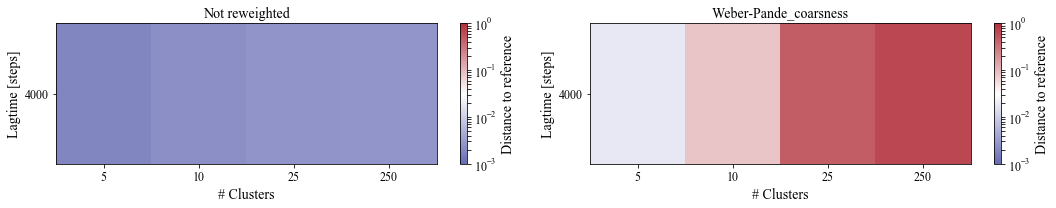

In [109]:

make_heatmap2(performance_dict_weber_rw_test_coarsness, performance_dict_weber_original_test_coarsness, reference_kin, eigenvalue_number=1, name_plot='Weber-Pande_coarsness')

('current eigenvalue is:', 1)


/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


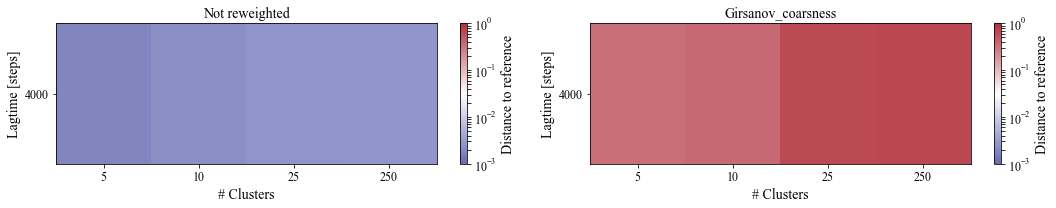

In [110]:
make_heatmap2(performance_dict_girsanov_rw_test_coarsness, performance_dict_girsanov_original_test_coarsness, reference_kin, eigenvalue_number=1, name_plot='Girsanov_coarsness')

## Test different time-dependent biases

In [93]:
# make MSM 

#MSM Parameters
#cluster data
numbins_q = 250    
v_min = 0.5
v_max = 10
qspace_g = np.linspace(v_min,v_max,numbins_q)

#discretize data
dtrajs_g_time = [np.digitize(data_new[k,:],qspace_g[1:]) for k in range(data.shape[0])] 

time_pos = [0.05, 0.01, 0.005, 0]

reference_kin = [29049528, 117247, 38157] 
reference_kinetics = 29132157

performance_dict_girsanov_original_test_timedep = {}
performance_dict_girsanov_rw_test_timedep = {}
performance_dict_weber_original_test_timedep = {}
performance_dict_weber_rw_test_timedep = {}

tlag = 4000 # lagtime 
u = (1-weight_factor)*get_potential(qspace)

for time_bias in time_pos:
    
        name = str(time_bias)
        C_gir = np.zeros((len(qspace_g),len(qspace_g)))
        Rws_gir = np.zeros((len(qspace_g),len(qspace_g)))
        Rws_weber = np.zeros((len(qspace_g),len(qspace_g)))

        print(time_bias)
        count_traj = 0
        
        while count_traj < numsims:

            #build count matrix 
            curr_sim = dtrajs_g_time[count_traj]
            l = len(curr_sim)
            for i in range(l- tlag):
                j = i + tlag
                C_gir[int(curr_sim[i]),int(curr_sim[j])] = C_gir[int(curr_sim[i]),int(curr_sim[j])] + 1 

            #Reweight transition matrix based on actions at Markov time
            for i in range(l- tlag):
                j = i + tlag

                g_gir = np.exp((-1./(T*k_B)*(energy[count_traj,i]+time_bias*i)))     #bias energy, added time dependent bias 
                w_gir = np.exp(np.sum(M_gir_I1[count_traj, i:j]- 0.5* M_gir_I2[count_traj, i:j]))
                Rws_gir[int(curr_sim[i]),int(curr_sim[j])] = Rws_gir[int(curr_sim[i]),int(curr_sim[j])] +  w_gir *g_gir
            
                #Reweight transition matrix Weber-Pande
                Rws_weber[int(curr_sim[i]),int(curr_sim[j])] = Rws_weber[int(curr_sim[i]),int(curr_sim[j])] + np.exp(np.sum(A_diff[count_traj , i:j]))
            count_traj += 1

    
        ###
        # Write data into dictionary
        ###

            
        ### Girsanov ###     
        try:

            #Normalize counts matrix
            P_rw_girsanov, P_norm_girsanov = get_transition_matrix(Rws_gir, C)
            # make markov model for kinetics 
            eigenvalues_rw_girsanov, eigenvalues_girsanov = plot_kinetic_spectrum(P_rw_girsanov, P_norm_girsanov, name='Girsanov', figure=False)

            print('Kinetics Girsanov [reweight, not reweight]')
            print(-lagtime/np.log(eigenvalues_rw_girsanov[1]), -lagtime/np.log(eigenvalues_girsanov[1]))
            
            # save in dictionary to later make heatmap plot
            performance_dict_girsanov_original_test_timedep[name] = -lagtime/np.log(eigenvalues_girsanov[:4])
            performance_dict_girsanov_rw_test_timedep[name] = -lagtime/np.log(eigenvalues_rw_girsanov[:4])
            
        except: 
            print(' Girsanov disconnected', cluster_n, lagtime)
            # save in dictionary to later make heatmap plot
            performance_dict_girsanov_original_test_timedep[name] = 0
            performance_dict_girsanov_rw_test_timedep[name] = 0
            
            
        ### Weber-Pande ###     
        try:

            #Normalize counts matrix
            P_rw_weber, P_norm_weber = get_transition_matrix(Rws_weber, C)
            # make markov model for kinetics 
            eigenvalues_rw_weber, eigenvalues_weber = plot_kinetic_spectrum(P_rw_weber, P_norm_weber, name='Weber-Pande', figure=False)

            print('Kinetics Weber-Pande [reweight, not reweight]')
            print(-lagtime/np.log(eigenvalues_rw_weber[1]), -lagtime/np.log(eigenvalues_weber[1]))
            
            # save in dictionary to later make heatmap plot
            performance_dict_weber_original_test_timedep[name] = -lagtime/np.log(eigenvalues_weber[:4])
            performance_dict_weber_rw_test_timedep[name] = -lagtime/np.log(eigenvalues_rw_weber[:4])
            
        except: 
            print(' Weber-Pande disconnected', cluster_n, lagtime)
            # save in dictionary to later make heatmap plot
            performance_dict_weber_original_test_timedep[name] = 0
            performance_dict_weber_rw_test_timedep[name] = 0

#save the dictionaries 

np.save('performance_dict_Girsanov_rw_test_timedep.npy', performance_dict_girsanov_rw_test_timedep)
np.save('performance_dict_Girsanov_original_test_timedep.npy', performance_dict_girsanov_original_test_timedep)
np.save('performance_dict_weber_rw_test_timedep.npy', performance_dict_weber_rw_test_timedep)
np.save('performance_dict_weber_original_test_timedep.npy', performance_dict_weber_original_test_timedep)

## Figure 1 B.2

('current eigenvalue is:', 1)


/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


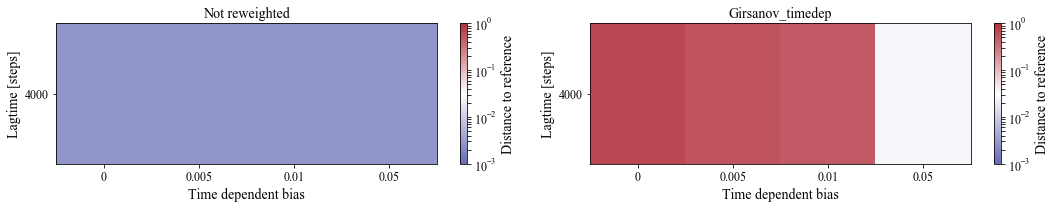

In [114]:
time_pos = [ 0 , 0.005, 0.01, 0.05]
make_heatmap3(performance_dict_girsanov_rw_test_timedep, performance_dict_girsanov_original_test_timedep, reference_kin, eigenvalue_number=1, name_plot='Girsanov_timedep')

('current eigenvalue is:', 1)


/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/stlinker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


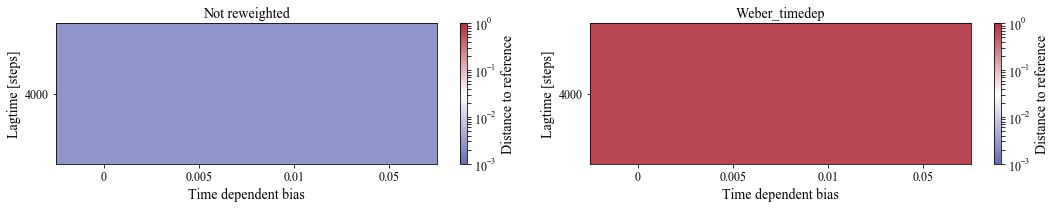

In [115]:
make_heatmap3(performance_dict_weber_rw_test_timedep, performance_dict_weber_original_test_timedep, reference_kin, eigenvalue_number=1, name_plot='Weber_timedep')